## Case 4

In this case study, we deal with **every 15 minutes prediction**. We will use 3 types of deep learning models to forecast an ICU adult patient's blood culture test results.
Input

> * ICU adults' vital signs and lab results in minutes

Output 

> * 3 categories of blood culture status -- positive / negative / no blood culture
> * label : positive VS negative + no blood culture

Classification strategy
> * summarize/use a certain length of per-minute inputs to every 15 minutes record since admission
> * train, test datasets split by subject

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import FAIRStream

## setup

In [6]:
# csv pool folder directory
csv_pool_path = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/csv_pool'
# current experiment working directory
work_dir = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case4'

In [7]:
# initiate a FAIRStream object instance for BSI project
bsi_stream = FAIRStream.FAIRStream(work_dir)
# take a look at dictionaries in engineer's hands
#bsi_stream.engineer.csv_source_dict
bsi_stream.engineer.variable_dict

Success: Querier has initiated a csv source dictionary in:/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case4/meta_data/csv_source_dict_demo.json
Success: Querier has initiated a variable dictionary in:/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case4/meta_data/variable_dict_demo.json
Unable to read sql source dictionary. Use Querier.update_sql_source_dict() to build one.


{'__uid': {'src_names': ['id', 'ID', 'subject_id', 'subject_id'],
  'label': 'unique subject id for current study',
  'unique_per_sbj': True},
 '__time': {'src_names': ['tsa', 'tsa', 'timeMinutes', 'timeMinutes'],
  'label': 'time since admission',
  'unit': 'minute'},
 '__anchor': {'src_names': ['True_positive', 'True positive'],
  'label': 'anchor for an episode',
  'unique_per_sbj': False,
  'factor': {'levels': {'__neg_nbc': ['0', '0.0', 'nan'],
    '__pos': ['1', '1.0']},
   'impute_per_sbj': {'nan_level': '__neg_nbc'}}},
 'y': {'output': True,
  'src_names': ['True_positive', 'True positive'],
  'label': 'Event outcome result',
  'unique_per_sbj': False,
  'factor': {'levels': {'neg_nbc': ['0', '0.0', 'nan'], 'pos': ['1', '1.0']},
   'impute_per_sbj': {'nan_level': 'neg_nbc'}}},
 'age': {'input': True,
  'src_names': ['age', 'AGE'],
  'label': 'age at admission',
  'unique_per_sbj': True,
  'numeric': {'scaler': 'none',
   'unit': 'year',
   'cutoff': {'quantile_min': 0.0001,
   

## Define Episode

In [8]:
# define an episode (notice that the engineer now has new attributes)
bsi_stream.engineer.DefineEpisode(input_time_len=4*24*60, # using vital signs and labs 4 days prior to a culture 
                                  output_time_len=1, # predict one time unit into the future
                                  time_resolution=60, # aggregate minutely data to one row per hour 
                                  time_lag=0,  # no time lag between predictors and response
                                  anchor_gap=7*24*60) # the minimum distance between two episodes

 
Success! An episode is defined to 
--- use 5760 minute(s) long input variables 
--- predict 1 minute(s) response variables into the future
--- lag 0 minute(s) between predictors and responses
--- increase by every 60 minute(s)
--- last at most 10080 minute(s) long
Success! Engineer has updated attributes --- episode. 


## Build MVTS (multi-variable time series) data objects
- train_df_imputed, valid_df_imputed and test_df_imputed are dataframes
- train_tfds, valid_tfds and test_tfds are tensorflow datasets

In [13]:
# Build MVTS dataframe or tfds  (notice that the engineer now has new attributes)
bsi_stream.engineer.BuildMVTS(csv_pool_path, 
                              nsbj = 100, # number of subjects / patients to sample from the pool 
                              valid_frac = 0.2, # fraction of number of subjects in validation dataset
                              test_frac = 0.1, # fraction of number of subjects in left-out test dataset
                              batch_size = 64, # batch size (usually 32,64,128..)
                              impute_input='median', # imputation on predictors
                              impute_output='median' )# imputation on response (no need in BSI project)

# please see the end of console 
# --- Success! Engineer has updated attributes --- train_df_imputed, valid_df_imputed and test_df_imputed. 
# --- Success! Engineer has updated attributes --- train_tfds, valid_tfds and test_tfds. 

Sucess!  100 out of 26093 subjects are sampled!
--- fix upper boundary for age by 110.0
--- fix lower boundary for age by 21.0
--- fix upper boundary for age by 110.0
--- fix lower boundary for age by 21.0
--- minmax scaling temp
--- fix upper boundary for heart_rate by nan
--- fix lower boundary for heart_rate by nan
--- fix upper boundary for systolic_blood_pressure by nan
--- fix lower boundary for systolic_blood_pressure by nan
--- fix upper boundary for diastolic_blood_pressure by nan
--- fix lower boundary for diastolic_blood_pressure by nan
--- fix upper boundary for resp_rate by nan
--- fix lower boundary for resp_rate by nan
--- fix upper boundary for glucose by nan
--- fix lower boundary for glucose by nan
--- fix upper boundary for bilirubin by nan
--- fix lower boundary for bilirubin by nan
--- fix upper boundary for potassium by nan
--- fix lower boundary for potassium by nan
--- fix upper boundary for albumin by nan
--- fix lower boundary for albumin by nan
--- fix upper 

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.955224
y___pos        0.044776
dtype: float64
--- prepare episodes for mimic_26241
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.955882
y___pos        0.044118
dtype: float64
--- prepare episodes for uva_5899
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.956522
y___pos        0.043478
dtype: float64
--- prepare episodes for mimic_23811
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.96
y___pos        0.04
dtype: float64
--- prepare episodes for mimic_22044
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.960526
y___pos        0.039474
dtype: float64
--- prepare episodes for mimic_11957
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.968085
y___pos        0.031915
dtype: float64
--- prepare episodes for uva_3187


Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.908451
y___pos        0.091549
dtype: float64
--- prepare episodes for mimic_20143
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.905263
y___pos        0.094737
dtype: float64
--- prepare episodes for uva_6800
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.905594
y___pos        0.094406
dtype: float64
--- prepare episodes for mimic_79667
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.908163
y___pos        0.091837
dtype: float64
--- prepare episodes for mimic_11718
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.908784
y___pos        0.091216
dtype: float64
--- prepare episodes for mimic_19096
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.909091
y___pos        0.090909
dtype: float64
--- prepare episodes for m

### print all the attributes of the engineer

In [11]:
bsi_stream.engineer.info()


----------------------------- Engineer Attributes List ------------------------

['work_dir', 'meta_dir', 'variable_dict', 'csv_source_dict', 'sql_source_dict', 'input_vars', 'output_vars', 'episode', 'sample_info', 'mvts_df', 'mvts_tfds', 'train_df', 'valid_df', 'test_df', 'train_df_imputed', 'valid_df_imputed', 'test_df_imputed', 'train_tfds', 'valid_tfds', 'test_tfds']

------------------------------------- Inputs  --------------------------------- 

['age___lab', 'age___vital', 'temp___vital', 'heart_rate___vital', 'systolic_blood_pressure___vital', 'diastolic_blood_pressure___vital', 'resp_rate___vital', 'glucose___vital', 'bilirubin___vital', 'potassium___vital', 'albumin___vital', 'calcium___vital', 'wbc___vital', 'creatinine___vital', 'platelet_count___vital', 'alt___vital', 'alp___vital', 'ast___vital', 'paco2___vital', 'chloride___vital', 'troponin___vital', 'ptt___vital', 'lactate___vital', 'bun___vital', 'magnesium___vital']

------------------------------------- Outputs -

## Modeling

In [10]:
myMetrics = [
    keras.metrics.AUC(name='AUROC', curve='ROC', multi_label=True),
    keras.metrics.AUC(name='AUPRC', curve='PR', multi_label=True),
]
    

train_tfds = bsi_stream.engineer.train_tfds
valid_tfds =  bsi_stream.engineer.valid_tfds
test_tfds = bsi_stream.engineer.test_tfds


train_tfds = train_tfds.map(lambda x, y: (x, tf.reshape(y, [-1, 2])))
valid_tfds = valid_tfds.map(lambda x, y: (x, tf.reshape(y, [-1, 2])))
test_tfds = test_tfds.map(lambda x, y: (x, tf.reshape(y, [-1, 2])))


keras.backend.clear_session()
input_shape = list(train_tfds.element_spec[0].shape)[1:3]
mdl = keras.models.Sequential([
    keras.layers.Flatten(input_shape=input_shape),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(2, activation='softmax')
])
mdl.summary()
mdl.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics = myMetrics)
callback = EarlyStopping(monitor='val_loss', patience=5)
his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-5)
his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-6)
his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2400)              0         
                                                                 
 batch_normalization (BatchN  (None, 2400)             9600      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 4802      
                                                                 
Total params: 14,402
Trainable params: 9,602
Non-trainable params: 4,800
_________________________________________________________________
Epoch 1/100
72/72 [==============================] - 2s 10ms/step - loss: 0.3187 - AUROC: 0.6961 - AUPRC: 0.7600 - val_loss: 0.8175 - val_AUROC: 0.6341 - val_AUPRC: 0.6505
Epoch 2/100
72/72 [==============================] - 0s 4ms/step - loss: 0.

## 10 fold bootstrap

In [ ]:
eval_df_trace_folds = pd.DataFrame()
myMetrics = [
    keras.metrics.AUC(name='AUROC', curve='ROC', multi_label=True),
    keras.metrics.AUC(name='AUPRC', curve='PR', multi_label=True),
]
# all subjects
for i in range(10):
    
    bsi_stream.engineer.BuildMVTS(csv_pool_path, nsbj=1000, valid_frac=0.2, test_frac=0, batch_size=32, impute_input='median', impute_output='median')
    train_tfds = bsi_stream.engineer.train_tfds
    valid_tfds = bsi_stream.engineer.valid_tfds
    
    train_tfds = train_tfds.map(lambda x, y: (x, tf.reshape(y, [-1, 2])))
    valid_tfds = valid_tfds.map(lambda x, y: (x, tf.reshape(y, [-1, 2])))
    
    eval_df_trace = pd.DataFrame()
    keras.backend.clear_session()
    input_shape = list(train_tfds.element_spec[0].shape)[1:3]
    mdl = keras.models.Sequential([
        keras.layers.Flatten(input_shape=input_shape),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(2, activation='softmax')
    ])
    mdl.summary()

    # compile and run the model
    mdl.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(lr=1e-3), metrics = myMetrics)
    callback = EarlyStopping(monitor='val_loss', patience=10)
    his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    
    
    keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
    his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    
    
    keras.backend.set_value(mdl.optimizer.learning_rate, 1e-5)
    his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    
    
    keras.backend.set_value(mdl.optimizer.learning_rate, 1e-6)
    his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    
    eval_df_trace['epoch'] = eval_df_trace.reset_index(drop=True).index
    eval_df_trace['fold'] = i + 1

    eval_df_trace_folds = pd.concat([eval_df_trace_folds, eval_df_trace],sort=False)
    

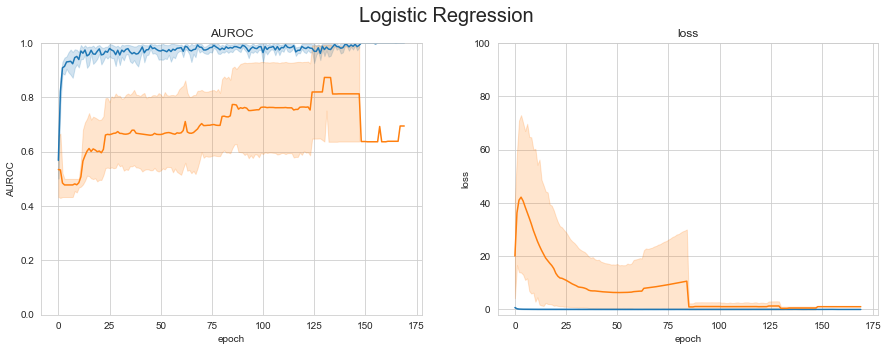

In [19]:
#eval_df_trace_folds.to_csv(work_dir+'/eval_mtrx.csv', index=False)
#data = pd.read_csv(work_dir+'/eval_mtrx.csv')
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Logistic Regression', fontsize=20)
axs = axs.flatten()
mtrx = 'AUROC'
sns.lineplot(x='epoch',y=mtrx, data=data, ax=axs[0])
sns.lineplot(x='epoch',y='val_'+mtrx, data=data, ax=axs[0])
axs[0].set_ylabel(mtrx)
axs[0].set_ylim(0,1)
axs[0].set_title(mtrx)
mtrx = 'loss'
sns.lineplot(x='epoch',y=mtrx, data=data, ax=axs[1])
sns.lineplot(x='epoch',y='val_'+mtrx, data=data, ax=axs[1])
axs[1].set_ylabel(mtrx)
axs[1].set_ylim(-2,100)
axs[1].set_title(mtrx)
plt.show();

# CNN + heatmap

In [54]:
# Build MVTS dataframe or tfds  (notice that the engineer now has new attributes)
bsi_stream.engineer.BuildMVTS(csv_pool_path, 
                              nsbj = 100, # number of subjects / patients to sample from the pool 
                              valid_frac = 0.2, # fraction of number of subjects in validation dataset
                              test_frac = 0.1, # fraction of number of subjects in left-out test dataset
                              batch_size = 64, # batch size (usually 32,64,128..)
                              impute_input='median', # imputation on predictors
                              impute_output='median' )# imputation on response (no need in BSI project)

# please see the end of console 
# --- Success! Engineer has updated attributes --- train_df_imputed, valid_df_imputed and test_df_imputed. 
# --- Success! Engineer has updated attributes --- train_tfds, valid_tfds and test_tfds. 

Sucess!  10000 out of 26093 subjects are sampled!
--- fix upper boundary for age by 110.0
--- fix lower boundary for age by 18.0
--- minmax scaling temp
--- fix upper boundary for heart_rate by nan
--- fix lower boundary for heart_rate by nan
--- fix upper boundary for systolic_blood_pressure by nan
--- fix lower boundary for systolic_blood_pressure by nan
--- fix upper boundary for diastolic_blood_pressure by nan
--- fix lower boundary for diastolic_blood_pressure by nan
--- fix upper boundary for resp_rate by nan
--- fix lower boundary for resp_rate by nan
--- fix upper boundary for glucose by nan
--- fix lower boundary for glucose by nan
--- fix upper boundary for bilirubin by nan
--- fix lower boundary for bilirubin by nan
--- fix upper boundary for potassium by nan
--- fix lower boundary for potassium by nan
--- fix upper boundary for albumin by nan
--- fix lower boundary for albumin by nan
--- fix upper boundary for calcium by nan
--- fix lower boundary for calcium by nan
--- fix

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.942308
y___pos        0.057692
dtype: float64
--- prepare episodes for mimic_52952
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.942675
y___pos        0.057325
dtype: float64
--- prepare episodes for uva_1172
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.943038
y___pos        0.056962
dtype: float64
--- prepare episodes for mimic_29511
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.952381
y___pos        0.047619
dtype: float64
--- prepare episodes for mimic_22797
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.954545
y___pos        0.045455
dtype: float64
--- prepare episodes for uva_1393
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.954774
y___pos        0.045226
dtype: float64
--- prepare episodes for mimi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.975275
y___pos        0.024725
dtype: float64
--- prepare episodes for uva_2373
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.975342
y___pos        0.024658
dtype: float64
--- prepare episodes for mimic_32652
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.975543
y___pos        0.024457
dtype: float64
--- prepare episodes for uva_6035
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.9729
y___pos        0.0271
dtype: float64
--- prepare episodes for uva_5543
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.972973
y___pos        0.027027
dtype: float64
--- prepare episodes for uva_785
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.973046
y___pos        0.026954
dtype: float64
--- prepare episodes for mimic_82851
Suc

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.964427
y___pos        0.035573
dtype: float64
--- prepare episodes for mimic_3980
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.964567
y___pos        0.035433
dtype: float64
--- prepare episodes for mimic_8466
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.964637
y___pos        0.035363
dtype: float64
--- prepare episodes for mimic_27758
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.965049
y___pos        0.034951
dtype: float64
--- prepare episodes for uva_7595
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.96139
y___pos        0.03861
dtype: float64
--- prepare episodes for mimic_7125
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.957774
y___pos        0.042226
dtype: float64
--- prepare episodes for mimic_

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.963636
y___pos        0.036364
dtype: float64
--- prepare episodes for mimic_47670
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.963691
y___pos        0.036309
dtype: float64
--- prepare episodes for mimic_6061
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.964861
y___pos        0.035139
dtype: float64
--- prepare episodes for mimic_2148
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.964912
y___pos        0.035088
dtype: float64
--- prepare episodes for mimic_42450
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.964964
y___pos        0.035036
dtype: float64
--- prepare episodes for mimic_60842
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.965015
y___pos        0.034985
dtype: float64
--- prepare episodes for 

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.96301
y___pos        0.03699
dtype: float64
--- prepare episodes for mimic_22132
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.963057
y___pos        0.036943
dtype: float64
--- prepare episodes for mimic_7363
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.960759
y___pos        0.039241
dtype: float64
--- prepare episodes for mimic_2428
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.960809
y___pos        0.039191
dtype: float64
--- prepare episodes for mimic_96093
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.960859
y___pos        0.039141
dtype: float64
--- prepare episodes for mimic_10442
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.960908
y___pos        0.039092
dtype: float64
--- prepare episodes for uv

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.958686
y___pos        0.041314
dtype: float64
--- prepare episodes for uva_3679
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.95873
y___pos        0.04127
dtype: float64
--- prepare episodes for mimic_25568
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.958774
y___pos        0.041226
dtype: float64
--- prepare episodes for mimic_19807
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.958817
y___pos        0.041183
dtype: float64
--- prepare episodes for mimic_29704
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.958861
y___pos        0.041139
dtype: float64
--- prepare episodes for uva_1755
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.958904
y___pos        0.041096
dtype: float64
--- prepare episodes for mimic_

y___neg_nbc    0.956485
y___pos        0.043515
dtype: float64
--- prepare episodes for mimic_76028
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.956522
y___pos        0.043478
dtype: float64
--- prepare episodes for uva_1005
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.956594
y___pos        0.043406
dtype: float64
--- prepare episodes for mimic_16238
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.956811
y___pos        0.043189
dtype: float64
--- prepare episodes for mimic_897
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.956918
y___pos        0.043082
dtype: float64
--- prepare episodes for uva_9572
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.956954
y___pos        0.043046
dtype: float64
--- prepare episodes for mimic_27596
Success! Output/responce variable mean in current sample space 

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.957831
y___pos        0.042169
dtype: float64
--- prepare episodes for mimic_2863
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.957895
y___pos        0.042105
dtype: float64
--- prepare episodes for mimic_95372
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.958084
y___pos        0.041916
dtype: float64
--- prepare episodes for mimic_12426
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.959683
y___pos        0.040317
dtype: float64
--- prepare episodes for mimic_42375
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.959712
y___pos        0.040288
dtype: float64
--- prepare episodes for uva_8570
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.959741
y___pos        0.040259
dtype: float64
--- prepare episodes for mi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.95921
y___pos        0.04079
dtype: float64
--- prepare episodes for mimic_98048
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.959236
y___pos        0.040764
dtype: float64
--- prepare episodes for mimic_20708
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.958625
y___pos        0.041375
dtype: float64
--- prepare episodes for mimic_84078
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.958651
y___pos        0.041349
dtype: float64
--- prepare episodes for mimic_16409
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.958678
y___pos        0.041322
dtype: float64
--- prepare episodes for mimic_58865
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.958704
y___pos        0.041296
dtype: float64
--- prepare episodes for 

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.957779
y___pos        0.042221
dtype: float64
--- prepare episodes for mimic_47146
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.957803
y___pos        0.042197
dtype: float64
--- prepare episodes for uva_9767
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.957828
y___pos        0.042172
dtype: float64
--- prepare episodes for uva_5716
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.957852
y___pos        0.042148
dtype: float64
--- prepare episodes for mimic_63167
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.957901
y___pos        0.042099
dtype: float64
--- prepare episodes for mimic_11323
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.958118
y___pos        0.041882
dtype: float64
--- prepare episodes for mimi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.957379
y___pos        0.042621
dtype: float64
--- prepare episodes for mimic_24118
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.957424
y___pos        0.042576
dtype: float64
--- prepare episodes for mimic_50689
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.957447
y___pos        0.042553
dtype: float64
--- prepare episodes for mimic_94908
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.957469
y___pos        0.042531
dtype: float64
--- prepare episodes for mimic_6466
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.956568
y___pos        0.043432
dtype: float64
--- prepare episodes for mimic_56965
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.956591
y___pos        0.043409
dtype: float64
--- prepare episodes for

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.955401
y___pos        0.044599
dtype: float64
--- prepare episodes for mimic_4461
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.955423
y___pos        0.044577
dtype: float64
--- prepare episodes for mimic_31469
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.95495
y___pos        0.04505
dtype: float64
--- prepare episodes for mimic_5845
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.95504
y___pos        0.04496
dtype: float64
--- prepare episodes for uva_7314
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.955062
y___pos        0.044938
dtype: float64
--- prepare episodes for uva_4777
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.955084
y___pos        0.044916
dtype: float64
--- prepare episodes for mimic_4226

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.95114
y___pos        0.04886
dtype: float64
--- prepare episodes for mimic_81592
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.951231
y___pos        0.048769
dtype: float64
--- prepare episodes for mimic_1777
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.951253
y___pos        0.048747
dtype: float64
--- prepare episodes for uva_7095
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.951276
y___pos        0.048724
dtype: float64
--- prepare episodes for uva_954
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.951299
y___pos        0.048701
dtype: float64
--- prepare episodes for mimic_7310
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.951546
y___pos        0.048454
dtype: float64
--- prepare episodes for mimic_221

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949263
y___pos        0.050737
dtype: float64
--- prepare episodes for mimic_25253
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949307
y___pos        0.050693
dtype: float64
--- prepare episodes for mimic_11172
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949351
y___pos        0.050649
dtype: float64
--- prepare episodes for mimic_62204
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94894
y___pos        0.05106
dtype: float64
--- prepare episodes for mimic_84320
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948962
y___pos        0.051038
dtype: float64
--- prepare episodes for mimic_51462
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948164
y___pos        0.051836
dtype: float64
--- prepare episodes for 

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.951032
y___pos        0.048968
dtype: float64
--- prepare episodes for mimic_24198
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.95119
y___pos        0.04881
dtype: float64
--- prepare episodes for uva_7248
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950423
y___pos        0.049577
dtype: float64
--- prepare episodes for mimic_19543
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950583
y___pos        0.049417
dtype: float64
--- prepare episodes for mimic_9692
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950602
y___pos        0.049398
dtype: float64
--- prepare episodes for uva_6015
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94986
y___pos        0.05014
dtype: float64
--- prepare episodes for mimic_412

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948786
y___pos        0.051214
dtype: float64
--- prepare episodes for mimic_31576
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948805
y___pos        0.051195
dtype: float64
--- prepare episodes for uva_9539
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948825
y___pos        0.051175
dtype: float64
--- prepare episodes for mimic_23872
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948718
y___pos        0.051282
dtype: float64
--- prepare episodes for uva_107
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948737
y___pos        0.051263
dtype: float64
--- prepare episodes for mimic_75438
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948776
y___pos        0.051224
dtype: float64
--- prepare episodes for uva_6

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950439
y___pos        0.049561
dtype: float64
--- prepare episodes for mimic_31974
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950457
y___pos        0.049543
dtype: float64
--- prepare episodes for mimic_61180
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950474
y___pos        0.049526
dtype: float64
--- prepare episodes for mimic_23233
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950561
y___pos        0.049439
dtype: float64
--- prepare episodes for mimic_70623
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950578
y___pos        0.049422
dtype: float64
--- prepare episodes for mimic_27349
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950665
y___pos        0.049335
dtype: float64
--- prepare episodes fo

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94929
y___pos        0.05071
dtype: float64
--- prepare episodes for uva_7264
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949307
y___pos        0.050693
dtype: float64
--- prepare episodes for mimic_9013
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949393
y___pos        0.050607
dtype: float64
--- prepare episodes for uva_4066
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948753
y___pos        0.051247
dtype: float64
--- prepare episodes for uva_7289
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948433
y___pos        0.051567
dtype: float64
--- prepare episodes for mimic_29552
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948658
y___pos        0.051342
dtype: float64
--- prepare episodes for mimic_2928

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947335
y___pos        0.052665
dtype: float64
--- prepare episodes for uva_7942
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947352
y___pos        0.052648
dtype: float64
--- prepare episodes for mimic_10857
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947368
y___pos        0.052632
dtype: float64
--- prepare episodes for mimic_23887
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947385
y___pos        0.052615
dtype: float64
--- prepare episodes for mimic_95406
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947402
y___pos        0.052598
dtype: float64
--- prepare episodes for mimic_60050
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947419
y___pos        0.052581
dtype: float64
--- prepare episodes for m

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948224
y___pos        0.051776
dtype: float64
--- prepare episodes for mimic_4254
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948333
y___pos        0.051667
dtype: float64
--- prepare episodes for mimic_77947
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948457
y___pos        0.051543
dtype: float64
--- prepare episodes for mimic_1389
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948472
y___pos        0.051528
dtype: float64
--- prepare episodes for mimic_97791
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948488
y___pos        0.051512
dtype: float64
--- prepare episodes for mimic_19606
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948503
y___pos        0.051497
dtype: float64
--- prepare episodes for 

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949646
y___pos        0.050354
dtype: float64
--- prepare episodes for uva_7973
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949661
y___pos        0.050339
dtype: float64
--- prepare episodes for mimic_11985
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949788
y___pos        0.050212
dtype: float64
--- prepare episodes for mimic_11756
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949873
y___pos        0.050127
dtype: float64
--- prepare episodes for mimic_54486
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949887
y___pos        0.050113
dtype: float64
--- prepare episodes for mimic_56343
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949901
y___pos        0.050099
dtype: float64
--- prepare episodes for u

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948788
y___pos        0.051212
dtype: float64
--- prepare episodes for uva_2165
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948802
y___pos        0.051198
dtype: float64
--- prepare episodes for mimic_65753
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948816
y___pos        0.051184
dtype: float64
--- prepare episodes for uva_7021
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948313
y___pos        0.051687
dtype: float64
--- prepare episodes for mimic_81245
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947454
y___pos        0.052546
dtype: float64
--- prepare episodes for mimic_28587
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947751
y___pos        0.052249
dtype: float64
--- prepare episodes for mimi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948342
y___pos        0.051658
dtype: float64
--- prepare episodes for mimic_13005
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947882
y___pos        0.052118
dtype: float64
--- prepare episodes for mimic_12847
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947909
y___pos        0.052091
dtype: float64
--- prepare episodes for mimic_16846
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947935
y___pos        0.052065
dtype: float64
--- prepare episodes for mimic_94164
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947949
y___pos        0.052051
dtype: float64
--- prepare episodes for mimic_81755
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947975
y___pos        0.052025
dtype: float64
--- prepare episodes fo

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948267
y___pos        0.051733
dtype: float64
--- prepare episodes for mimic_51256
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94828
y___pos        0.05172
dtype: float64
--- prepare episodes for mimic_16630
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948293
y___pos        0.051707
dtype: float64
--- prepare episodes for uva_4303
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948306
y___pos        0.051694
dtype: float64
--- prepare episodes for uva_4803
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948318
y___pos        0.051682
dtype: float64
--- prepare episodes for mimic_26628
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948548
y___pos        0.051452
dtype: float64
--- prepare episodes for mimic_

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949446
y___pos        0.050554
dtype: float64
--- prepare episodes for mimic_83692
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949458
y___pos        0.050542
dtype: float64
--- prepare episodes for mimic_72723
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949469
y___pos        0.050531
dtype: float64
--- prepare episodes for mimic_64160
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949528
y___pos        0.050472
dtype: float64
--- prepare episodes for mimic_60778
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949539
y___pos        0.050461
dtype: float64
--- prepare episodes for uva_4247
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949551
y___pos        0.050449
dtype: float64
--- prepare episodes for m

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949587
y___pos        0.050413
dtype: float64
--- prepare episodes for uva_2073
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949376
y___pos        0.050624
dtype: float64
--- prepare episodes for mimic_90609
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948964
y___pos        0.051036
dtype: float64
--- prepare episodes for uva_8672
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948975
y___pos        0.051025
dtype: float64
--- prepare episodes for mimic_79079
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948986
y___pos        0.051014
dtype: float64
--- prepare episodes for mimic_67427
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948775
y___pos        0.051225
dtype: float64
--- prepare episodes for uva_

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948607
y___pos        0.051393
dtype: float64
--- prepare episodes for mimic_63213
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948618
y___pos        0.051382
dtype: float64
--- prepare episodes for uva_6507
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948414
y___pos        0.051586
dtype: float64
--- prepare episodes for mimic_11269
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948447
y___pos        0.051553
dtype: float64
--- prepare episodes for mimic_27364
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94848
y___pos        0.05152
dtype: float64
--- prepare episodes for mimic_30064
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948491
y___pos        0.051509
dtype: float64
--- prepare episodes for mim

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947632
y___pos        0.052368
dtype: float64
--- prepare episodes for mimic_76437
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947643
y___pos        0.052357
dtype: float64
--- prepare episodes for uva_6953
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947654
y___pos        0.052346
dtype: float64
--- prepare episodes for mimic_27688
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947576
y___pos        0.052424
dtype: float64
--- prepare episodes for mimic_84908
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947586
y___pos        0.052414
dtype: float64
--- prepare episodes for mimic_19959
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947608
y___pos        0.052392
dtype: float64
--- prepare episodes for u

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948439
y___pos        0.051561
dtype: float64
--- prepare episodes for mimic_9776
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948449
y___pos        0.051551
dtype: float64
--- prepare episodes for mimic_47852
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94846
y___pos        0.05154
dtype: float64
--- prepare episodes for mimic_54904
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94847
y___pos        0.05153
dtype: float64
--- prepare episodes for uva_620
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948481
y___pos        0.051519
dtype: float64
--- prepare episodes for mimic_12761
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948522
y___pos        0.051478
dtype: float64
--- prepare episodes for mimic_1

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949053
y___pos        0.050947
dtype: float64
--- prepare episodes for mimic_2953
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949133
y___pos        0.050867
dtype: float64
--- prepare episodes for mimic_83498
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949143
y___pos        0.050857
dtype: float64
--- prepare episodes for mimic_17027
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949212
y___pos        0.050788
dtype: float64
--- prepare episodes for mimic_28309
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948892
y___pos        0.051108
dtype: float64
--- prepare episodes for uva_3204
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948902
y___pos        0.051098
dtype: float64
--- prepare episodes for uv

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949878
y___pos        0.050122
dtype: float64
--- prepare episodes for mimic_22696
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949887
y___pos        0.050113
dtype: float64
--- prepare episodes for mimic_66785
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949897
y___pos        0.050103
dtype: float64
--- prepare episodes for uva_9538
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949906
y___pos        0.050094
dtype: float64
--- prepare episodes for mimic_52732
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949728
y___pos        0.050272
dtype: float64
--- prepare episodes for mimic_30472
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949737
y___pos        0.050263
dtype: float64
--- prepare episodes for m

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949249
y___pos        0.050751
dtype: float64
--- prepare episodes for mimic_70273
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949258
y___pos        0.050742
dtype: float64
--- prepare episodes for uva_3721
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949267
y___pos        0.050733
dtype: float64
--- prepare episodes for mimic_55679
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949277
y___pos        0.050723
dtype: float64
--- prepare episodes for mimic_31462
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949295
y___pos        0.050705
dtype: float64
--- prepare episodes for mimic_85672
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949305
y___pos        0.050695
dtype: float64
--- prepare episodes for u

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950071
y___pos        0.049929
dtype: float64
--- prepare episodes for mimic_17962
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950097
y___pos        0.049903
dtype: float64
--- prepare episodes for mimic_32107
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950106
y___pos        0.049894
dtype: float64
--- prepare episodes for uva_4431
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950115
y___pos        0.049885
dtype: float64
--- prepare episodes for uva_7207
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950123
y___pos        0.049877
dtype: float64
--- prepare episodes for mimic_69398
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950185
y___pos        0.049815
dtype: float64
--- prepare episodes for mimi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.951503
y___pos        0.048497
dtype: float64
--- prepare episodes for mimic_42590
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.951511
y___pos        0.048489
dtype: float64
--- prepare episodes for mimic_19509
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.951519
y___pos        0.048481
dtype: float64
--- prepare episodes for mimic_20558
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.951561
y___pos        0.048439
dtype: float64
--- prepare episodes for mimic_52484
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.951569
y___pos        0.048431
dtype: float64
--- prepare episodes for mimic_72993
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.951407
y___pos        0.048593
dtype: float64
--- prepare episodes fo

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950902
y___pos        0.049098
dtype: float64
--- prepare episodes for mimic_3711
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950918
y___pos        0.049082
dtype: float64
--- prepare episodes for mimic_57872
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950926
y___pos        0.049074
dtype: float64
--- prepare episodes for mimic_14328
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950943
y___pos        0.049057
dtype: float64
--- prepare episodes for mimic_42062
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950951
y___pos        0.049049
dtype: float64
--- prepare episodes for mimic_78946
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.951
y___pos        0.049
dtype: float64
--- prepare episodes for mimic

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950575
y___pos        0.049425
dtype: float64
--- prepare episodes for mimic_31274
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950583
y___pos        0.049417
dtype: float64
--- prepare episodes for uva_7375
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950591
y___pos        0.049409
dtype: float64
--- prepare episodes for mimic_82490
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950283
y___pos        0.049717
dtype: float64
--- prepare episodes for mimic_745
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949887
y___pos        0.050113
dtype: float64
--- prepare episodes for mimic_76586
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949895
y___pos        0.050105
dtype: float64
--- prepare episodes for uva

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949968
y___pos        0.050032
dtype: float64
--- prepare episodes for mimic_90937
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949976
y___pos        0.050024
dtype: float64
--- prepare episodes for mimic_5762
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949992
y___pos        0.050008
dtype: float64
--- prepare episodes for uva_119
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.95
y___pos        0.05
dtype: float64
--- prepare episodes for uva_3946
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950008
y___pos        0.049992
dtype: float64
--- prepare episodes for mimic_24102
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950016
y___pos        0.049984
dtype: float64
--- prepare episodes for mimic_11667
Su

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949721
y___pos        0.050279
dtype: float64
--- prepare episodes for mimic_73316
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949728
y___pos        0.050272
dtype: float64
--- prepare episodes for mimic_21847
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949744
y___pos        0.050256
dtype: float64
--- prepare episodes for mimic_7235
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94976
y___pos        0.05024
dtype: float64
--- prepare episodes for mimic_81359
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949767
y___pos        0.050233
dtype: float64
--- prepare episodes for mimic_87172
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949775
y___pos        0.050225
dtype: float64
--- prepare episodes for m

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948548
y___pos        0.051452
dtype: float64
--- prepare episodes for mimic_85352
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948556
y___pos        0.051444
dtype: float64
--- prepare episodes for uva_6211
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948564
y___pos        0.051436
dtype: float64
--- prepare episodes for mimic_27909
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948579
y___pos        0.051421
dtype: float64
--- prepare episodes for mimic_83682
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948595
y___pos        0.051405
dtype: float64
--- prepare episodes for uva_1169
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948602
y___pos        0.051398
dtype: float64
--- prepare episodes for mimi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947577
y___pos        0.052423
dtype: float64
--- prepare episodes for uva_1191
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947584
y___pos        0.052416
dtype: float64
--- prepare episodes for mimic_82434
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947592
y___pos        0.052408
dtype: float64
--- prepare episodes for mimic_20245
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947607
y___pos        0.052393
dtype: float64
--- prepare episodes for uva_1711
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947615
y___pos        0.052385
dtype: float64
--- prepare episodes for mimic_10299
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947345
y___pos        0.052655
dtype: float64
--- prepare episodes for mimi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947845
y___pos        0.052155
dtype: float64
--- prepare episodes for mimic_18406
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947905
y___pos        0.052095
dtype: float64
--- prepare episodes for mimic_5056
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947912
y___pos        0.052088
dtype: float64
--- prepare episodes for mimic_78309
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94792
y___pos        0.05208
dtype: float64
--- prepare episodes for mimic_94300
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947927
y___pos        0.052073
dtype: float64
--- prepare episodes for mimic_95925
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947685
y___pos        0.052315
dtype: float64
--- prepare episodes for m

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.9483
y___pos        0.0517
dtype: float64
--- prepare episodes for mimic_52323
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948344
y___pos        0.051656
dtype: float64
--- prepare episodes for mimic_56147
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948351
y___pos        0.051649
dtype: float64
--- prepare episodes for mimic_83062
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948365
y___pos        0.051635
dtype: float64
--- prepare episodes for mimic_10637
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948394
y___pos        0.051606
dtype: float64
--- prepare episodes for mimic_86645
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948402
y___pos        0.051598
dtype: float64
--- prepare episodes for mi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948728
y___pos        0.051272
dtype: float64
--- prepare episodes for mimic_15378
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948735
y___pos        0.051265
dtype: float64
--- prepare episodes for uva_2248
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948742
y___pos        0.051258
dtype: float64
--- prepare episodes for mimic_8049
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948756
y___pos        0.051244
dtype: float64
--- prepare episodes for mimic_32161
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948819
y___pos        0.051181
dtype: float64
--- prepare episodes for mimic_93671
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948826
y___pos        0.051174
dtype: float64
--- prepare episodes for mi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948612
y___pos        0.051388
dtype: float64
--- prepare episodes for mimic_80629
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948619
y___pos        0.051381
dtype: float64
--- prepare episodes for mimic_18543
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948632
y___pos        0.051368
dtype: float64
--- prepare episodes for mimic_64846
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948639
y___pos        0.051361
dtype: float64
--- prepare episodes for uva_4097
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948646
y___pos        0.051354
dtype: float64
--- prepare episodes for uva_7352
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948653
y___pos        0.051347
dtype: float64
--- prepare episodes for mimi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949124
y___pos        0.050876
dtype: float64
--- prepare episodes for mimic_20124
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949005
y___pos        0.050995
dtype: float64
--- prepare episodes for mimic_60142
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949058
y___pos        0.050942
dtype: float64
--- prepare episodes for mimic_20043
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949064
y___pos        0.050936
dtype: float64
--- prepare episodes for mimic_24837
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949078
y___pos        0.050922
dtype: float64
--- prepare episodes for mimic_49176
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949091
y___pos        0.050909
dtype: float64
--- prepare episodes fo

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949614
y___pos        0.050386
dtype: float64
--- prepare episodes for mimic_9494
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949639
y___pos        0.050361
dtype: float64
--- prepare episodes for uva_7983
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949646
y___pos        0.050354
dtype: float64
--- prepare episodes for mimic_1995
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949658
y___pos        0.050342
dtype: float64
--- prepare episodes for mimic_2682
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949678
y___pos        0.050322
dtype: float64
--- prepare episodes for mimic_61181
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949684
y___pos        0.050316
dtype: float64
--- prepare episodes for mimi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949827
y___pos        0.050173
dtype: float64
--- prepare episodes for mimic_26828
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949833
y___pos        0.050167
dtype: float64
--- prepare episodes for mimic_21663
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949845
y___pos        0.050155
dtype: float64
--- prepare episodes for uva_6302
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949851
y___pos        0.050149
dtype: float64
--- prepare episodes for mimic_48483
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949746
y___pos        0.050254
dtype: float64
--- prepare episodes for uva_4962
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949752
y___pos        0.050248
dtype: float64
--- prepare episodes for mimi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94909
y___pos        0.05091
dtype: float64
--- prepare episodes for mimic_7524
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949097
y___pos        0.050903
dtype: float64
--- prepare episodes for mimic_67460
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949196
y___pos        0.050804
dtype: float64
--- prepare episodes for mimic_6016
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949208
y___pos        0.050792
dtype: float64
--- prepare episodes for mimic_58019
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949227
y___pos        0.050773
dtype: float64
--- prepare episodes for uva_8909
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949233
y___pos        0.050767
dtype: float64
--- prepare episodes for mimic

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948883
y___pos        0.051117
dtype: float64
--- prepare episodes for mimic_91289
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948889
y___pos        0.051111
dtype: float64
--- prepare episodes for uva_1141
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948896
y___pos        0.051104
dtype: float64
--- prepare episodes for mimic_87868
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948914
y___pos        0.051086
dtype: float64
--- prepare episodes for mimic_83920
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94892
y___pos        0.05108
dtype: float64
--- prepare episodes for mimic_66507
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948932
y___pos        0.051068
dtype: float64
--- prepare episodes for uva

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948408
y___pos        0.051592
dtype: float64
--- prepare episodes for mimic_21202
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948288
y___pos        0.051712
dtype: float64
--- prepare episodes for mimic_22634
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948294
y___pos        0.051706
dtype: float64
--- prepare episodes for mimic_44266
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.9483
y___pos        0.0517
dtype: float64
--- prepare episodes for mimic_75244
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948306
y___pos        0.051694
dtype: float64
--- prepare episodes for uva_1309
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948312
y___pos        0.051688
dtype: float64
--- prepare episodes for mimic

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947648
y___pos        0.052352
dtype: float64
--- prepare episodes for mimic_56579
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947654
y___pos        0.052346
dtype: float64
--- prepare episodes for mimic_88306
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947666
y___pos        0.052334
dtype: float64
--- prepare episodes for mimic_97714
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947678
y___pos        0.052322
dtype: float64
--- prepare episodes for uva_7265
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947684
y___pos        0.052316
dtype: float64
--- prepare episodes for mimic_93208
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947691
y___pos        0.052309
dtype: float64
--- prepare episodes for m

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947386
y___pos        0.052614
dtype: float64
--- prepare episodes for mimic_90755
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947398
y___pos        0.052602
dtype: float64
--- prepare episodes for mimic_84052
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947404
y___pos        0.052596
dtype: float64
--- prepare episodes for mimic_27527
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947422
y___pos        0.052578
dtype: float64
--- prepare episodes for mimic_14947
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947434
y___pos        0.052566
dtype: float64
--- prepare episodes for mimic_21369
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947458
y___pos        0.052542
dtype: float64
--- prepare episodes fo

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947086
y___pos        0.052914
dtype: float64
--- prepare episodes for uva_3650
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94688
y___pos        0.05312
dtype: float64
--- prepare episodes for uva_542
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946886
y___pos        0.053114
dtype: float64
--- prepare episodes for mimic_40442
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946892
y___pos        0.053108
dtype: float64
--- prepare episodes for mimic_28272
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946921
y___pos        0.053079
dtype: float64
--- prepare episodes for mimic_96147
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946927
y___pos        0.053073
dtype: float64
--- prepare episodes for mimic_7

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947188
y___pos        0.052812
dtype: float64
--- prepare episodes for uva_721
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947194
y___pos        0.052806
dtype: float64
--- prepare episodes for mimic_24866
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947217
y___pos        0.052783
dtype: float64
--- prepare episodes for mimic_77195
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947351
y___pos        0.052649
dtype: float64
--- prepare episodes for mimic_11710
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947392
y___pos        0.052608
dtype: float64
--- prepare episodes for mimic_16405
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947397
y___pos        0.052603
dtype: float64
--- prepare episodes for mi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94871
y___pos        0.05129
dtype: float64
--- prepare episodes for uva_3322
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948715
y___pos        0.051285
dtype: float64
--- prepare episodes for mimic_18484
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94862
y___pos        0.05138
dtype: float64
--- prepare episodes for mimic_94786
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948625
y___pos        0.051375
dtype: float64
--- prepare episodes for uva_2955
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948423
y___pos        0.051577
dtype: float64
--- prepare episodes for uva_2342
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948322
y___pos        0.051678
dtype: float64
--- prepare episodes for uva_6764
Su

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948523
y___pos        0.051477
dtype: float64
--- prepare episodes for mimic_30248
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948539
y___pos        0.051461
dtype: float64
--- prepare episodes for mimic_62102
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948544
y___pos        0.051456
dtype: float64
--- prepare episodes for uva_5929
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948549
y___pos        0.051451
dtype: float64
--- prepare episodes for mimic_26601
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948624
y___pos        0.051376
dtype: float64
--- prepare episodes for mimic_67222
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94863
y___pos        0.05137
dtype: float64
--- prepare episodes for mim

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949434
y___pos        0.050566
dtype: float64
--- prepare episodes for mimic_70226
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949496
y___pos        0.050504
dtype: float64
--- prepare episodes for mimic_6557
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949501
y___pos        0.050499
dtype: float64
--- prepare episodes for mimic_79799
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949506
y___pos        0.050494
dtype: float64
--- prepare episodes for mimic_16197
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949511
y___pos        0.050489
dtype: float64
--- prepare episodes for mimic_28072
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949415
y___pos        0.050585
dtype: float64
--- prepare episodes for

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94946
y___pos        0.05054
dtype: float64
--- prepare episodes for uva_3927
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949465
y___pos        0.050535
dtype: float64
--- prepare episodes for mimic_62187
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94947
y___pos        0.05053
dtype: float64
--- prepare episodes for uva_4297
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949476
y___pos        0.050524
dtype: float64
--- prepare episodes for mimic_13274
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949481
y___pos        0.050519
dtype: float64
--- prepare episodes for mimic_21693
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949532
y___pos        0.050468
dtype: float64
--- prepare episodes for uva_8924

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949519
y___pos        0.050481
dtype: float64
--- prepare episodes for mimic_55440
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949524
y___pos        0.050476
dtype: float64
--- prepare episodes for mimic_30601
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949574
y___pos        0.050426
dtype: float64
--- prepare episodes for uva_3727
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949579
y___pos        0.050421
dtype: float64
--- prepare episodes for mimic_21730
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949589
y___pos        0.050411
dtype: float64
--- prepare episodes for mimic_95039
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949594
y___pos        0.050406
dtype: float64
--- prepare episodes for m

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949765
y___pos        0.050235
dtype: float64
--- prepare episodes for mimic_7695
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949844
y___pos        0.050156
dtype: float64
--- prepare episodes for uva_1190
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949848
y___pos        0.050152
dtype: float64
--- prepare episodes for mimic_13053
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949863
y___pos        0.050137
dtype: float64
--- prepare episodes for mimic_88569
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949868
y___pos        0.050132
dtype: float64
--- prepare episodes for uva_6955
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949873
y___pos        0.050127
dtype: float64
--- prepare episodes for mimic

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950034
y___pos        0.049966
dtype: float64
--- prepare episodes for mimic_93084
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950038
y___pos        0.049962
dtype: float64
--- prepare episodes for mimic_18995
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950043
y___pos        0.049957
dtype: float64
--- prepare episodes for mimic_75488
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950048
y___pos        0.049952
dtype: float64
--- prepare episodes for mimic_30509
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950086
y___pos        0.049914
dtype: float64
--- prepare episodes for mimic_3442
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950125
y___pos        0.049875
dtype: float64
--- prepare episodes for

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94941
y___pos        0.05059
dtype: float64
--- prepare episodes for mimic_8081
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94965
y___pos        0.05035
dtype: float64
--- prepare episodes for mimic_68663
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949655
y___pos        0.050345
dtype: float64
--- prepare episodes for mimic_11334
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949664
y___pos        0.050336
dtype: float64
--- prepare episodes for mimic_6865
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949669
y___pos        0.050331
dtype: float64
--- prepare episodes for uva_2353
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949674
y___pos        0.050326
dtype: float64
--- prepare episodes for mimic_9

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950046
y___pos        0.049954
dtype: float64
--- prepare episodes for mimic_5062
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950056
y___pos        0.049944
dtype: float64
--- prepare episodes for mimic_11860
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950111
y___pos        0.049889
dtype: float64
--- prepare episodes for mimic_19048
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950116
y___pos        0.049884
dtype: float64
--- prepare episodes for mimic_87869
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949958
y___pos        0.050042
dtype: float64
--- prepare episodes for mimic_91758
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949963
y___pos        0.050037
dtype: float64
--- prepare episodes for

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950036
y___pos        0.049964
dtype: float64
--- prepare episodes for mimic_31973
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.95005
y___pos        0.04995
dtype: float64
--- prepare episodes for mimic_27805
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950054
y___pos        0.049946
dtype: float64
--- prepare episodes for mimic_11144
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950059
y___pos        0.049941
dtype: float64
--- prepare episodes for mimic_12740
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949977
y___pos        0.050023
dtype: float64
--- prepare episodes for uva_6261
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949982
y___pos        0.050018
dtype: float64
--- prepare episodes for mim

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950344
y___pos        0.049656
dtype: float64
--- prepare episodes for mimic_55529
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950353
y___pos        0.049647
dtype: float64
--- prepare episodes for mimic_21413
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950512
y___pos        0.049488
dtype: float64
--- prepare episodes for uva_6458
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950516
y___pos        0.049484
dtype: float64
--- prepare episodes for mimic_17629
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950529
y___pos        0.049471
dtype: float64
--- prepare episodes for mimic_13384
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950534
y___pos        0.049466
dtype: float64
--- prepare episodes for m

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950026
y___pos        0.049974
dtype: float64
--- prepare episodes for mimic_82853
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949943
y___pos        0.050057
dtype: float64
--- prepare episodes for mimic_57485
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949956
y___pos        0.050044
dtype: float64
--- prepare episodes for mimic_29823
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949873
y___pos        0.050127
dtype: float64
--- prepare episodes for mimic_84457
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949882
y___pos        0.050118
dtype: float64
--- prepare episodes for mimic_78127
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949886
y___pos        0.050114
dtype: float64
--- prepare episodes fo

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.95003
y___pos        0.04997
dtype: float64
--- prepare episodes for mimic_59314
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.950151
y___pos        0.049849
dtype: float64
--- prepare episodes for uva_3061
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949991
y___pos        0.050009
dtype: float64
--- prepare episodes for uva_229
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949996
y___pos        0.050004
dtype: float64
--- prepare episodes for mimic_20143
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949913
y___pos        0.050087
dtype: float64
--- prepare episodes for mimic_66596
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949836
y___pos        0.050164
dtype: float64
--- prepare episodes for mimic_1

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94961
y___pos        0.05039
dtype: float64
--- prepare episodes for mimic_24377
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949614
y___pos        0.050386
dtype: float64
--- prepare episodes for mimic_74404
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949619
y___pos        0.050381
dtype: float64
--- prepare episodes for mimic_17782
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949559
y___pos        0.050441
dtype: float64
--- prepare episodes for mimic_22623
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949572
y___pos        0.050428
dtype: float64
--- prepare episodes for mimic_7554
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949589
y___pos        0.050411
dtype: float64
--- prepare episodes for m

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949315
y___pos        0.050685
dtype: float64
--- prepare episodes for uva_4448
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949319
y___pos        0.050681
dtype: float64
--- prepare episodes for mimic_28150
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949323
y___pos        0.050677
dtype: float64
--- prepare episodes for mimic_32810
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949332
y___pos        0.050668
dtype: float64
--- prepare episodes for uva_3947
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949336
y___pos        0.050664
dtype: float64
--- prepare episodes for mimic_15486
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949345
y___pos        0.050655
dtype: float64
--- prepare episodes for mimi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948989
y___pos        0.051011
dtype: float64
--- prepare episodes for mimic_21860
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948998
y___pos        0.051002
dtype: float64
--- prepare episodes for mimic_28125
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949023
y___pos        0.050977
dtype: float64
--- prepare episodes for mimic_82574
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949027
y___pos        0.050973
dtype: float64
--- prepare episodes for uva_7270
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949032
y___pos        0.050968
dtype: float64
--- prepare episodes for mimic_30276
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.949036
y___pos        0.050964
dtype: float64
--- prepare episodes for u

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948187
y___pos        0.051813
dtype: float64
--- prepare episodes for mimic_32216
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.9482
y___pos        0.0518
dtype: float64
--- prepare episodes for mimic_27867
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948205
y___pos        0.051795
dtype: float64
--- prepare episodes for mimic_64
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94823
y___pos        0.05177
dtype: float64
--- prepare episodes for mimic_7947
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948235
y___pos        0.051765
dtype: float64
--- prepare episodes for mimic_14412
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948247
y___pos        0.051753
dtype: float64
--- prepare episodes for mimic_29

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948819
y___pos        0.051181
dtype: float64
--- prepare episodes for mimic_81223
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948831
y___pos        0.051169
dtype: float64
--- prepare episodes for uva_8567
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94868
y___pos        0.05132
dtype: float64
--- prepare episodes for mimic_59669
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948684
y___pos        0.051316
dtype: float64
--- prepare episodes for mimic_55729
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948689
y___pos        0.051311
dtype: float64
--- prepare episodes for mimic_48546
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948705
y___pos        0.051295
dtype: float64
--- prepare episodes for uva

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948851
y___pos        0.051149
dtype: float64
--- prepare episodes for mimic_5662
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948768
y___pos        0.051232
dtype: float64
--- prepare episodes for mimic_9770
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948772
y___pos        0.051228
dtype: float64
--- prepare episodes for uva_6626
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948776
y___pos        0.051224
dtype: float64
--- prepare episodes for mimic_72083
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948788
y___pos        0.051212
dtype: float64
--- prepare episodes for mimic_49565
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948793
y___pos        0.051207
dtype: float64
--- prepare episodes for mim

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94806
y___pos        0.05194
dtype: float64
--- prepare episodes for mimic_30353
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948077
y___pos        0.051923
dtype: float64
--- prepare episodes for mimic_31503
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948081
y___pos        0.051919
dtype: float64
--- prepare episodes for mimic_45994
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948085
y___pos        0.051915
dtype: float64
--- prepare episodes for mimic_82229
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948094
y___pos        0.051906
dtype: float64
--- prepare episodes for uva_8646
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948098
y___pos        0.051902
dtype: float64
--- prepare episodes for uva

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948773
y___pos        0.051227
dtype: float64
--- prepare episodes for mimic_94592
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948781
y___pos        0.051219
dtype: float64
--- prepare episodes for mimic_29739
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948785
y___pos        0.051215
dtype: float64
--- prepare episodes for mimic_2564
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948789
y___pos        0.051211
dtype: float64
--- prepare episodes for mimic_70003
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948793
y___pos        0.051207
dtype: float64
--- prepare episodes for uva_2047
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948797
y___pos        0.051203
dtype: float64
--- prepare episodes for mi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948792
y___pos        0.051208
dtype: float64
--- prepare episodes for mimic_51891
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.9488
y___pos        0.0512
dtype: float64
--- prepare episodes for uva_2169
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948804
y___pos        0.051196
dtype: float64
--- prepare episodes for uva_5932
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948808
y___pos        0.051192
dtype: float64
--- prepare episodes for uva_3044
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948812
y___pos        0.051188
dtype: float64
--- prepare episodes for uva_461
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948816
y___pos        0.051184
dtype: float64
--- prepare episodes for mimic_12303
Suc

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948791
y___pos        0.051209
dtype: float64
--- prepare episodes for uva_5709
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948799
y___pos        0.051201
dtype: float64
--- prepare episodes for uva_9889
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948726
y___pos        0.051274
dtype: float64
--- prepare episodes for uva_5522
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94873
y___pos        0.05127
dtype: float64
--- prepare episodes for mimic_20333
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948734
y___pos        0.051266
dtype: float64
--- prepare episodes for mimic_92278
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948738
y___pos        0.051262
dtype: float64
--- prepare episodes for uva_5755


Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948412
y___pos        0.051588
dtype: float64
--- prepare episodes for mimic_27577
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948468
y___pos        0.051532
dtype: float64
--- prepare episodes for uva_9903
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948472
y___pos        0.051528
dtype: float64
--- prepare episodes for mimic_63539
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94848
y___pos        0.05152
dtype: float64
--- prepare episodes for mimic_86123
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948484
y___pos        0.051516
dtype: float64
--- prepare episodes for mimic_11596
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948531
y___pos        0.051469
dtype: float64
--- prepare episodes for mim

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948471
y___pos        0.051529
dtype: float64
--- prepare episodes for mimic_29316
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94851
y___pos        0.05149
dtype: float64
--- prepare episodes for uva_4671
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948514
y___pos        0.051486
dtype: float64
--- prepare episodes for uva_4857
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948518
y___pos        0.051482
dtype: float64
--- prepare episodes for mimic_3395
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948522
y___pos        0.051478
dtype: float64
--- prepare episodes for mimic_32287
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.948454
y___pos        0.051546
dtype: float64
--- prepare episodes for mimic_6

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947685
y___pos        0.052315
dtype: float64
--- prepare episodes for mimic_68477
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947693
y___pos        0.052307
dtype: float64
--- prepare episodes for mimic_87206
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947701
y___pos        0.052299
dtype: float64
--- prepare episodes for mimic_1026
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947705
y___pos        0.052295
dtype: float64
--- prepare episodes for mimic_42771
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947708
y___pos        0.052292
dtype: float64
--- prepare episodes for mimic_3251
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947712
y___pos        0.052288
dtype: float64
--- prepare episodes for 

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947365
y___pos        0.052635
dtype: float64
--- prepare episodes for mimic_12049
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947372
y___pos        0.052628
dtype: float64
--- prepare episodes for mimic_7577
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947376
y___pos        0.052624
dtype: float64
--- prepare episodes for mimic_4252
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94738
y___pos        0.05262
dtype: float64
--- prepare episodes for mimic_56157
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947384
y___pos        0.052616
dtype: float64
--- prepare episodes for uva_4461
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947388
y___pos        0.052612
dtype: float64
--- prepare episodes for mimic

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947064
y___pos        0.052936
dtype: float64
--- prepare episodes for mimic_9447
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947084
y___pos        0.052916
dtype: float64
--- prepare episodes for mimic_65196
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947088
y___pos        0.052912
dtype: float64
--- prepare episodes for uva_1296
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947091
y___pos        0.052909
dtype: float64
--- prepare episodes for uva_8482
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947095
y___pos        0.052905
dtype: float64
--- prepare episodes for mimic_23039
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947134
y___pos        0.052866
dtype: float64
--- prepare episodes for mimic

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947232
y___pos        0.052768
dtype: float64
--- prepare episodes for mimic_49232
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947236
y___pos        0.052764
dtype: float64
--- prepare episodes for mimic_51439
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947239
y___pos        0.052761
dtype: float64
--- prepare episodes for mimic_23389
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947243
y___pos        0.052757
dtype: float64
--- prepare episodes for mimic_62034
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947247
y___pos        0.052753
dtype: float64
--- prepare episodes for mimic_67058
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947251
y___pos        0.052749
dtype: float64
--- prepare episodes fo

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946837
y___pos        0.053163
dtype: float64
--- prepare episodes for mimic_71341
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946856
y___pos        0.053144
dtype: float64
--- prepare episodes for mimic_17682
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946793
y___pos        0.053207
dtype: float64
--- prepare episodes for mimic_75828
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946796
y___pos        0.053204
dtype: float64
--- prepare episodes for mimic_13563
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.9468
y___pos        0.0532
dtype: float64
--- prepare episodes for mimic_61816
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946672
y___pos        0.053328
dtype: float64
--- prepare episodes for mi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946793
y___pos        0.053207
dtype: float64
--- prepare episodes for mimic_93054
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.9468
y___pos        0.0532
dtype: float64
--- prepare episodes for uva_4528
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946804
y___pos        0.053196
dtype: float64
--- prepare episodes for mimic_24777
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946719
y___pos        0.053281
dtype: float64
--- prepare episodes for mimic_4623
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946723
y___pos        0.053277
dtype: float64
--- prepare episodes for mimic_55308
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946727
y___pos        0.053273
dtype: float64
--- prepare episodes for uva_40

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946052
y___pos        0.053948
dtype: float64
--- prepare episodes for uva_1424
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946055
y___pos        0.053945
dtype: float64
--- prepare episodes for uva_6054
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946059
y___pos        0.053941
dtype: float64
--- prepare episodes for uva_7981
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946063
y___pos        0.053937
dtype: float64
--- prepare episodes for mimic_31039
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946067
y___pos        0.053933
dtype: float64
--- prepare episodes for mimic_21948
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946074
y___pos        0.053926
dtype: float64
--- prepare episodes for mimic_1

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946221
y___pos        0.053779
dtype: float64
--- prepare episodes for mimic_47901
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946225
y___pos        0.053775
dtype: float64
--- prepare episodes for mimic_40205
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946228
y___pos        0.053772
dtype: float64
--- prepare episodes for mimic_89645
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946232
y___pos        0.053768
dtype: float64
--- prepare episodes for mimic_3250
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94624
y___pos        0.05376
dtype: float64
--- prepare episodes for mimic_87586
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946243
y___pos        0.053757
dtype: float64
--- prepare episodes for u

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946263
y___pos        0.053737
dtype: float64
--- prepare episodes for mimic_25408
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946267
y___pos        0.053733
dtype: float64
--- prepare episodes for mimic_91532
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946271
y___pos        0.053729
dtype: float64
--- prepare episodes for mimic_94414
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946274
y___pos        0.053726
dtype: float64
--- prepare episodes for uva_1222
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946278
y___pos        0.053722
dtype: float64
--- prepare episodes for mimic_22972
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946282
y___pos        0.053718
dtype: float64
--- prepare episodes for u

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946256
y___pos        0.053744
dtype: float64
--- prepare episodes for uva_2043
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946259
y___pos        0.053741
dtype: float64
--- prepare episodes for mimic_65579
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946263
y___pos        0.053737
dtype: float64
--- prepare episodes for uva_6846
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946138
y___pos        0.053862
dtype: float64
--- prepare episodes for mimic_51275
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946061
y___pos        0.053939
dtype: float64
--- prepare episodes for mimic_51179
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946068
y___pos        0.053932
dtype: float64
--- prepare episodes for mimi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946188
y___pos        0.053812
dtype: float64
--- prepare episodes for mimic_22417
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946192
y___pos        0.053808
dtype: float64
--- prepare episodes for mimic_74129
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946196
y___pos        0.053804
dtype: float64
--- prepare episodes for mimic_30747
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946203
y___pos        0.053797
dtype: float64
--- prepare episodes for mimic_4290
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94621
y___pos        0.05379
dtype: float64
--- prepare episodes for mimic_49095
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946214
y___pos        0.053786
dtype: float64
--- prepare episodes for m

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945959
y___pos        0.054041
dtype: float64
--- prepare episodes for uva_6540
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945962
y___pos        0.054038
dtype: float64
--- prepare episodes for mimic_9241
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945969
y___pos        0.054031
dtype: float64
--- prepare episodes for mimic_83449
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945973
y___pos        0.054027
dtype: float64
--- prepare episodes for uva_6061
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945976
y___pos        0.054024
dtype: float64
--- prepare episodes for mimic_87936
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945984
y___pos        0.054016
dtype: float64
--- prepare episodes for mimic

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946434
y___pos        0.053566
dtype: float64
--- prepare episodes for uva_7656
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946438
y___pos        0.053562
dtype: float64
--- prepare episodes for mimic_77675
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946441
y___pos        0.053559
dtype: float64
--- prepare episodes for mimic_150
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946459
y___pos        0.053541
dtype: float64
--- prepare episodes for mimic_9976
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946487
y___pos        0.053513
dtype: float64
--- prepare episodes for mimic_24223
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946491
y___pos        0.053509
dtype: float64
--- prepare episodes for mimi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94626
y___pos        0.05374
dtype: float64
--- prepare episodes for mimic_12181
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946264
y___pos        0.053736
dtype: float64
--- prepare episodes for uva_3164
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946267
y___pos        0.053733
dtype: float64
--- prepare episodes for mimic_55188
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946274
y___pos        0.053726
dtype: float64
--- prepare episodes for mimic_25320
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946347
y___pos        0.053653
dtype: float64
--- prepare episodes for mimic_22245
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946361
y___pos        0.053639
dtype: float64
--- prepare episodes for mim

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946478
y___pos        0.053522
dtype: float64
--- prepare episodes for mimic_4448
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946526
y___pos        0.053474
dtype: float64
--- prepare episodes for mimic_3475
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94653
y___pos        0.05347
dtype: float64
--- prepare episodes for uva_2186
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946533
y___pos        0.053467
dtype: float64
--- prepare episodes for uva_4583
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946536
y___pos        0.053464
dtype: float64
--- prepare episodes for mimic_81754
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946567
y___pos        0.053433
dtype: float64
--- prepare episodes for mimic_20

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946853
y___pos        0.053147
dtype: float64
--- prepare episodes for mimic_87963
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946863
y___pos        0.053137
dtype: float64
--- prepare episodes for mimic_14451
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946867
y___pos        0.053133
dtype: float64
--- prepare episodes for mimic_12821
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94687
y___pos        0.05313
dtype: float64
--- prepare episodes for mimic_55354
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946873
y___pos        0.053127
dtype: float64
--- prepare episodes for mimic_27540
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946877
y___pos        0.053123
dtype: float64
--- prepare episodes for 

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946762
y___pos        0.053238
dtype: float64
--- prepare episodes for mimic_30117
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946765
y___pos        0.053235
dtype: float64
--- prepare episodes for mimic_61670
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946769
y___pos        0.053231
dtype: float64
--- prepare episodes for mimic_54825
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946775
y___pos        0.053225
dtype: float64
--- prepare episodes for mimic_14256
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946799
y___pos        0.053201
dtype: float64
--- prepare episodes for mimic_18447
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946802
y___pos        0.053198
dtype: float64
--- prepare episodes fo

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946857
y___pos        0.053143
dtype: float64
--- prepare episodes for mimic_13436
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94687
y___pos        0.05313
dtype: float64
--- prepare episodes for mimic_69498
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946873
y___pos        0.053127
dtype: float64
--- prepare episodes for mimic_27179
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946876
y___pos        0.053124
dtype: float64
--- prepare episodes for mimic_32618
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94688
y___pos        0.05312
dtype: float64
--- prepare episodes for mimic_13165
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946883
y___pos        0.053117
dtype: float64
--- prepare episodes for uv

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946375
y___pos        0.053625
dtype: float64
--- prepare episodes for uva_1608
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946378
y___pos        0.053622
dtype: float64
--- prepare episodes for mimic_49359
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94632
y___pos        0.05368
dtype: float64
--- prepare episodes for mimic_89416
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946323
y___pos        0.053677
dtype: float64
--- prepare episodes for uva_2123
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946326
y___pos        0.053674
dtype: float64
--- prepare episodes for mimic_29043
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946285
y___pos        0.053715
dtype: float64
--- prepare episodes for mimic_

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946744
y___pos        0.053256
dtype: float64
--- prepare episodes for mimic_24432
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946748
y___pos        0.053252
dtype: float64
--- prepare episodes for mimic_89906
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946767
y___pos        0.053233
dtype: float64
--- prepare episodes for uva_1226
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94677
y___pos        0.05323
dtype: float64
--- prepare episodes for mimic_88613
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946774
y___pos        0.053226
dtype: float64
--- prepare episodes for mimic_54368
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946777
y___pos        0.053223
dtype: float64
--- prepare episodes for mim

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947025
y___pos        0.052975
dtype: float64
--- prepare episodes for mimic_28860
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947041
y___pos        0.052959
dtype: float64
--- prepare episodes for mimic_18657
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.947077
y___pos        0.052923
dtype: float64
--- prepare episodes for mimic_30434
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94708
y___pos        0.05292
dtype: float64
--- prepare episodes for mimic_75350
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946966
y___pos        0.053034
dtype: float64
--- prepare episodes for uva_4634
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946969
y___pos        0.053031
dtype: float64
--- prepare episodes for mim

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946947
y___pos        0.053053
dtype: float64
--- prepare episodes for mimic_30408
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94696
y___pos        0.05304
dtype: float64
--- prepare episodes for mimic_54826
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946966
y___pos        0.053034
dtype: float64
--- prepare episodes for mimic_12272
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946979
y___pos        0.053021
dtype: float64
--- prepare episodes for mimic_96049
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946982
y___pos        0.053018
dtype: float64
--- prepare episodes for mimic_58730
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946988
y___pos        0.053012
dtype: float64
--- prepare episodes for 

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946526
y___pos        0.053474
dtype: float64
--- prepare episodes for uva_9877
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946529
y___pos        0.053471
dtype: float64
--- prepare episodes for mimic_26086
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946577
y___pos        0.053423
dtype: float64
--- prepare episodes for mimic_2144
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946589
y___pos        0.053411
dtype: float64
--- prepare episodes for mimic_75761
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946592
y___pos        0.053408
dtype: float64
--- prepare episodes for mimic_7818
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946596
y___pos        0.053404
dtype: float64
--- prepare episodes for mim

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946497
y___pos        0.053503
dtype: float64
--- prepare episodes for uva_9016
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.9465
y___pos        0.0535
dtype: float64
--- prepare episodes for mimic_73990
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946503
y___pos        0.053497
dtype: float64
--- prepare episodes for mimic_21745
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946532
y___pos        0.053468
dtype: float64
--- prepare episodes for uva_6981
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946423
y___pos        0.053577
dtype: float64
--- prepare episodes for mimic_52302
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946426
y___pos        0.053574
dtype: float64
--- prepare episodes for mimic_36

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946443
y___pos        0.053557
dtype: float64
--- prepare episodes for uva_2882
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946446
y___pos        0.053554
dtype: float64
--- prepare episodes for mimic_16917
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946506
y___pos        0.053494
dtype: float64
--- prepare episodes for mimic_62564
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946509
y___pos        0.053491
dtype: float64
--- prepare episodes for mimic_90830
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946515
y___pos        0.053485
dtype: float64
--- prepare episodes for mimic_8892
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946349
y___pos        0.053651
dtype: float64
--- prepare episodes for mi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945688
y___pos        0.054312
dtype: float64
--- prepare episodes for mimic_5215
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945636
y___pos        0.054364
dtype: float64
--- prepare episodes for uva_19
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94564
y___pos        0.05436
dtype: float64
--- prepare episodes for uva_7913
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945643
y___pos        0.054357
dtype: float64
--- prepare episodes for mimic_3941
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945671
y___pos        0.054329
dtype: float64
--- prepare episodes for uva_8026
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945674
y___pos        0.054326
dtype: float64
--- prepare episodes for mimic_25073
S

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945677
y___pos        0.054323
dtype: float64
--- prepare episodes for mimic_8986
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94568
y___pos        0.05432
dtype: float64
--- prepare episodes for mimic_14664
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94569
y___pos        0.05431
dtype: float64
--- prepare episodes for mimic_13339
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945693
y___pos        0.054307
dtype: float64
--- prepare episodes for uva_8392
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945696
y___pos        0.054304
dtype: float64
--- prepare episodes for mimic_97023
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945702
y___pos        0.054298
dtype: float64
--- prepare episodes for mimic_

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945864
y___pos        0.054136
dtype: float64
--- prepare episodes for mimic_11897
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945904
y___pos        0.054096
dtype: float64
--- prepare episodes for mimic_91520
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945914
y___pos        0.054086
dtype: float64
--- prepare episodes for mimic_58522
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945917
y___pos        0.054083
dtype: float64
--- prepare episodes for uva_168
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94592
y___pos        0.05408
dtype: float64
--- prepare episodes for mimic_21071
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945929
y___pos        0.054071
dtype: float64
--- prepare episodes for mimi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946346
y___pos        0.053654
dtype: float64
--- prepare episodes for mimic_66517
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946295
y___pos        0.053705
dtype: float64
--- prepare episodes for mimic_29965
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946305
y___pos        0.053695
dtype: float64
--- prepare episodes for mimic_52829
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946308
y___pos        0.053692
dtype: float64
--- prepare episodes for mimic_42530
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946311
y___pos        0.053689
dtype: float64
--- prepare episodes for uva_9816
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946314
y___pos        0.053686
dtype: float64
--- prepare episodes for m

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946328
y___pos        0.053672
dtype: float64
--- prepare episodes for mimic_27442
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946331
y___pos        0.053669
dtype: float64
--- prepare episodes for mimic_51045
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946334
y___pos        0.053666
dtype: float64
--- prepare episodes for uva_6813
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946337
y___pos        0.053663
dtype: float64
--- prepare episodes for mimic_94229
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946343
y___pos        0.053657
dtype: float64
--- prepare episodes for mimic_71797
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946346
y___pos        0.053654
dtype: float64
--- prepare episodes for m

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945768
y___pos        0.054232
dtype: float64
--- prepare episodes for mimic_5609
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945792
y___pos        0.054208
dtype: float64
--- prepare episodes for mimic_77988
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945795
y___pos        0.054205
dtype: float64
--- prepare episodes for mimic_89124
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945807
y___pos        0.054193
dtype: float64
--- prepare episodes for uva_3942
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94581
y___pos        0.05419
dtype: float64
--- prepare episodes for mimic_5676
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945813
y___pos        0.054187
dtype: float64
--- prepare episodes for mimic

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945353
y___pos        0.054647
dtype: float64
--- prepare episodes for mimic_76327
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94529
y___pos        0.05471
dtype: float64
--- prepare episodes for uva_2352
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945293
y___pos        0.054707
dtype: float64
--- prepare episodes for mimic_80880
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945296
y___pos        0.054704
dtype: float64
--- prepare episodes for uva_4525
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.9453
y___pos        0.0547
dtype: float64
--- prepare episodes for uva_113
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945303
y___pos        0.054697
dtype: float64
--- prepare episodes for mimic_24292
Su

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944631
y___pos        0.055369
dtype: float64
--- prepare episodes for mimic_64314
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944634
y___pos        0.055366
dtype: float64
--- prepare episodes for mimic_42071
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944637
y___pos        0.055363
dtype: float64
--- prepare episodes for mimic_7492
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944643
y___pos        0.055357
dtype: float64
--- prepare episodes for mimic_18612
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944649
y___pos        0.055351
dtype: float64
--- prepare episodes for mimic_29364
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944676
y___pos        0.055324
dtype: float64
--- prepare episodes for

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944823
y___pos        0.055177
dtype: float64
--- prepare episodes for mimic_96244
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944826
y___pos        0.055174
dtype: float64
--- prepare episodes for mimic_24810
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944832
y___pos        0.055168
dtype: float64
--- prepare episodes for mimic_7419
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944838
y___pos        0.055162
dtype: float64
--- prepare episodes for uva_3522
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944842
y___pos        0.055158
dtype: float64
--- prepare episodes for mimic_95324
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944845
y___pos        0.055155
dtype: float64
--- prepare episodes for mi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945212
y___pos        0.054788
dtype: float64
--- prepare episodes for mimic_17024
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94523
y___pos        0.05477
dtype: float64
--- prepare episodes for uva_6357
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945233
y___pos        0.054767
dtype: float64
--- prepare episodes for uva_8385
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945236
y___pos        0.054764
dtype: float64
--- prepare episodes for mimic_97061
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945239
y___pos        0.054761
dtype: float64
--- prepare episodes for mimic_22293
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945242
y___pos        0.054758
dtype: float64
--- prepare episodes for mimic_

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945094
y___pos        0.054906
dtype: float64
--- prepare episodes for uva_611
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945097
y___pos        0.054903
dtype: float64
--- prepare episodes for uva_4503
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.9451
y___pos        0.0549
dtype: float64
--- prepare episodes for mimic_25865
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945121
y___pos        0.054879
dtype: float64
--- prepare episodes for mimic_14417
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945144
y___pos        0.054856
dtype: float64
--- prepare episodes for mimic_42872
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945147
y___pos        0.054853
dtype: float64
--- prepare episodes for mimic_612

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945226
y___pos        0.054774
dtype: float64
--- prepare episodes for uva_474
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945076
y___pos        0.054924
dtype: float64
--- prepare episodes for mimic_81385
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945079
y___pos        0.054921
dtype: float64
--- prepare episodes for mimic_14038
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944982
y___pos        0.055018
dtype: float64
--- prepare episodes for uva_5014
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944985
y___pos        0.055015
dtype: float64
--- prepare episodes for mimic_68044
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944988
y___pos        0.055012
dtype: float64
--- prepare episodes for mimic

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945062
y___pos        0.054938
dtype: float64
--- prepare episodes for mimic_32014
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945085
y___pos        0.054915
dtype: float64
--- prepare episodes for mimic_8114
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945088
y___pos        0.054912
dtype: float64
--- prepare episodes for mimic_84650
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945091
y___pos        0.054909
dtype: float64
--- prepare episodes for mimic_17176
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945094
y___pos        0.054906
dtype: float64
--- prepare episodes for mimic_84718
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945045
y___pos        0.054955
dtype: float64
--- prepare episodes for

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945455
y___pos        0.054545
dtype: float64
--- prepare episodes for uva_2706
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945457
y___pos        0.054543
dtype: float64
--- prepare episodes for uva_3123
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94546
y___pos        0.05454
dtype: float64
--- prepare episodes for mimic_10104
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945466
y___pos        0.054534
dtype: float64
--- prepare episodes for mimic_16284
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945469
y___pos        0.054531
dtype: float64
--- prepare episodes for mimic_14222
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945471
y___pos        0.054529
dtype: float64
--- prepare episodes for mimic_

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945526
y___pos        0.054474
dtype: float64
--- prepare episodes for uva_8016
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945529
y___pos        0.054471
dtype: float64
--- prepare episodes for mimic_11719
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945557
y___pos        0.054443
dtype: float64
--- prepare episodes for mimic_77024
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94556
y___pos        0.05444
dtype: float64
--- prepare episodes for mimic_17677
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945566
y___pos        0.054434
dtype: float64
--- prepare episodes for mimic_50936
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945568
y___pos        0.054432
dtype: float64
--- prepare episodes for mim

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945814
y___pos        0.054186
dtype: float64
--- prepare episodes for mimic_8662
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94582
y___pos        0.05418
dtype: float64
--- prepare episodes for uva_9172
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945726
y___pos        0.054274
dtype: float64
--- prepare episodes for uva_4767
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945729
y___pos        0.054271
dtype: float64
--- prepare episodes for uva_7161
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945732
y___pos        0.054268
dtype: float64
--- prepare episodes for mimic_30642
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945737
y___pos        0.054263
dtype: float64
--- prepare episodes for uva_4492
S

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945675
y___pos        0.054325
dtype: float64
--- prepare episodes for uva_660
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945677
y___pos        0.054323
dtype: float64
--- prepare episodes for mimic_12709
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945668
y___pos        0.054332
dtype: float64
--- prepare episodes for mimic_15898
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945682
y___pos        0.054318
dtype: float64
--- prepare episodes for mimic_25454
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945684
y___pos        0.054316
dtype: float64
--- prepare episodes for mimic_69654
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94569
y___pos        0.05431
dtype: float64
--- prepare episodes for uva_

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945829
y___pos        0.054171
dtype: float64
--- prepare episodes for mimic_23890
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945834
y___pos        0.054166
dtype: float64
--- prepare episodes for mimic_5362
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945772
y___pos        0.054228
dtype: float64
--- prepare episodes for uva_7526
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94568
y___pos        0.05432
dtype: float64
--- prepare episodes for mimic_89348
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945683
y___pos        0.054317
dtype: float64
--- prepare episodes for mimic_80889
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945688
y___pos        0.054312
dtype: float64
--- prepare episodes for mimi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945974
y___pos        0.054026
dtype: float64
--- prepare episodes for mimic_66903
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945977
y___pos        0.054023
dtype: float64
--- prepare episodes for mimic_43120
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945979
y___pos        0.054021
dtype: float64
--- prepare episodes for mimic_25853
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945982
y___pos        0.054018
dtype: float64
--- prepare episodes for mimic_29501
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945993
y___pos        0.054007
dtype: float64
--- prepare episodes for mimic_10050
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945995
y___pos        0.054005
dtype: float64
--- prepare episodes fo

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945624
y___pos        0.054376
dtype: float64
--- prepare episodes for mimic_53019
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945627
y___pos        0.054373
dtype: float64
--- prepare episodes for uva_2080
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945581
y___pos        0.054419
dtype: float64
--- prepare episodes for uva_5133
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945488
y___pos        0.054512
dtype: float64
--- prepare episodes for mimic_13607
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945493
y___pos        0.054507
dtype: float64
--- prepare episodes for mimic_27680
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945501
y___pos        0.054499
dtype: float64
--- prepare episodes for mimi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945896
y___pos        0.054104
dtype: float64
--- prepare episodes for uva_1133
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945899
y___pos        0.054101
dtype: float64
--- prepare episodes for mimic_83013
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945904
y___pos        0.054096
dtype: float64
--- prepare episodes for mimic_53310
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945907
y___pos        0.054093
dtype: float64
--- prepare episodes for uva_4614
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945909
y___pos        0.054091
dtype: float64
--- prepare episodes for mimic_92816
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945912
y___pos        0.054088
dtype: float64
--- prepare episodes for mimi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946063
y___pos        0.053937
dtype: float64
--- prepare episodes for uva_2015
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946066
y___pos        0.053934
dtype: float64
--- prepare episodes for mimic_27874
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946068
y___pos        0.053932
dtype: float64
--- prepare episodes for mimic_5749
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946071
y___pos        0.053929
dtype: float64
--- prepare episodes for uva_675
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946074
y___pos        0.053926
dtype: float64
--- prepare episodes for mimic_11879
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945985
y___pos        0.054015
dtype: float64
--- prepare episodes for mimic_

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946022
y___pos        0.053978
dtype: float64
--- prepare episodes for mimic_11114
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946025
y___pos        0.053975
dtype: float64
--- prepare episodes for mimic_28528
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94603
y___pos        0.05397
dtype: float64
--- prepare episodes for mimic_41781
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946033
y___pos        0.053967
dtype: float64
--- prepare episodes for mimic_50440
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946038
y___pos        0.053962
dtype: float64
--- prepare episodes for mimic_6212
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946046
y___pos        0.053954
dtype: float64
--- prepare episodes for m

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946148
y___pos        0.053852
dtype: float64
--- prepare episodes for mimic_28573
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94615
y___pos        0.05385
dtype: float64
--- prepare episodes for mimic_73579
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946158
y___pos        0.053842
dtype: float64
--- prepare episodes for mimic_13666
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946166
y___pos        0.053834
dtype: float64
--- prepare episodes for mimic_65267
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946123
y___pos        0.053877
dtype: float64
--- prepare episodes for mimic_84531
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946033
y___pos        0.053967
dtype: float64
--- prepare episodes for 

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.946001
y___pos        0.053999
dtype: float64
--- prepare episodes for mimic_21926
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945959
y___pos        0.054041
dtype: float64
--- prepare episodes for mimic_98344
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945869
y___pos        0.054131
dtype: float64
--- prepare episodes for mimic_60274
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94583
y___pos        0.05417
dtype: float64
--- prepare episodes for uva_8473
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945832
y___pos        0.054168
dtype: float64
--- prepare episodes for mimic_17743
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945858
y___pos        0.054142
dtype: float64
--- prepare episodes for mim

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945639
y___pos        0.054361
dtype: float64
--- prepare episodes for mimic_8501
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945649
y___pos        0.054351
dtype: float64
--- prepare episodes for mimic_67744
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945654
y___pos        0.054346
dtype: float64
--- prepare episodes for uva_372
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945657
y___pos        0.054343
dtype: float64
--- prepare episodes for mimic_31069
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945662
y___pos        0.054338
dtype: float64
--- prepare episodes for mimic_3981
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945664
y___pos        0.054336
dtype: float64
--- prepare episodes for uva_

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945449
y___pos        0.054551
dtype: float64
--- prepare episodes for mimic_2625
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945457
y___pos        0.054543
dtype: float64
--- prepare episodes for uva_5380
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94546
y___pos        0.05454
dtype: float64
--- prepare episodes for uva_7271
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945416
y___pos        0.054584
dtype: float64
--- prepare episodes for mimic_14227
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945418
y___pos        0.054582
dtype: float64
--- prepare episodes for mimic_95977
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945421
y___pos        0.054579
dtype: float64
--- prepare episodes for mimic_5

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945204
y___pos        0.054796
dtype: float64
--- prepare episodes for mimic_42870
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945206
y___pos        0.054794
dtype: float64
--- prepare episodes for mimic_19834
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945209
y___pos        0.054791
dtype: float64
--- prepare episodes for uva_3985
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945211
y___pos        0.054789
dtype: float64
--- prepare episodes for mimic_56819
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945214
y___pos        0.054786
dtype: float64
--- prepare episodes for mimic_51358
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945216
y___pos        0.054784
dtype: float64
--- prepare episodes for m

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94521
y___pos        0.05479
dtype: float64
--- prepare episodes for mimic_14229
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945217
y___pos        0.054783
dtype: float64
--- prepare episodes for mimic_3429
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945255
y___pos        0.054745
dtype: float64
--- prepare episodes for mimic_6200
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94526
y___pos        0.05474
dtype: float64
--- prepare episodes for mimic_9951
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945222
y___pos        0.054778
dtype: float64
--- prepare episodes for uva_7883
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945224
y___pos        0.054776
dtype: float64
--- prepare episodes for mimic_89

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945237
y___pos        0.054763
dtype: float64
--- prepare episodes for mimic_74966
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945244
y___pos        0.054756
dtype: float64
--- prepare episodes for uva_846
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945247
y___pos        0.054753
dtype: float64
--- prepare episodes for mimic_17655
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945256
y___pos        0.054744
dtype: float64
--- prepare episodes for uva_2330
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945259
y___pos        0.054741
dtype: float64
--- prepare episodes for uva_7908
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945261
y___pos        0.054739
dtype: float64
--- prepare episodes for mimic_12

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94495
y___pos        0.05505
dtype: float64
--- prepare episodes for mimic_81334
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944952
y___pos        0.055048
dtype: float64
--- prepare episodes for uva_6282
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944955
y___pos        0.055045
dtype: float64
--- prepare episodes for mimic_9741
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944967
y___pos        0.055033
dtype: float64
--- prepare episodes for mimic_65611
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944969
y___pos        0.055031
dtype: float64
--- prepare episodes for mimic_32387
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945019
y___pos        0.054981
dtype: float64
--- prepare episodes for mimi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945135
y___pos        0.054865
dtype: float64
--- prepare episodes for mimic_58861
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945138
y___pos        0.054862
dtype: float64
--- prepare episodes for mimic_70514
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94514
y___pos        0.05486
dtype: float64
--- prepare episodes for mimic_45698
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945143
y___pos        0.054857
dtype: float64
--- prepare episodes for mimic_4978
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945145
y___pos        0.054855
dtype: float64
--- prepare episodes for mimic_77676
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945153
y___pos        0.054847
dtype: float64
--- prepare episodes for m

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945097
y___pos        0.054903
dtype: float64
--- prepare episodes for mimic_11236
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945212
y___pos        0.054788
dtype: float64
--- prepare episodes for mimic_41863
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945215
y___pos        0.054785
dtype: float64
--- prepare episodes for mimic_29690
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945249
y___pos        0.054751
dtype: float64
--- prepare episodes for mimic_2056
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945268
y___pos        0.054732
dtype: float64
--- prepare episodes for mimic_30129
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945273
y___pos        0.054727
dtype: float64
--- prepare episodes for

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945368
y___pos        0.054632
dtype: float64
--- prepare episodes for uva_1240
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94537
y___pos        0.05463
dtype: float64
--- prepare episodes for uva_6719
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945372
y___pos        0.054628
dtype: float64
--- prepare episodes for uva_9371
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945377
y___pos        0.054623
dtype: float64
--- prepare episodes for mimic_3652
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94538
y___pos        0.05462
dtype: float64
--- prepare episodes for uva_9474
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945382
y___pos        0.054618
dtype: float64
--- prepare episodes for mimic_6967
Succ

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945386
y___pos        0.054614
dtype: float64
--- prepare episodes for mimic_52846
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945389
y___pos        0.054611
dtype: float64
--- prepare episodes for mimic_58055
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945306
y___pos        0.054694
dtype: float64
--- prepare episodes for mimic_26932
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945322
y___pos        0.054678
dtype: float64
--- prepare episodes for mimic_42271
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945325
y___pos        0.054675
dtype: float64
--- prepare episodes for mimic_18583
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945339
y___pos        0.054661
dtype: float64
--- prepare episodes fo

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94526
y___pos        0.05474
dtype: float64
--- prepare episodes for mimic_71380
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945263
y___pos        0.054737
dtype: float64
--- prepare episodes for mimic_4909
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945265
y___pos        0.054735
dtype: float64
--- prepare episodes for mimic_16298
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945318
y___pos        0.054682
dtype: float64
--- prepare episodes for mimic_22695
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94532
y___pos        0.05468
dtype: float64
--- prepare episodes for mimic_3281
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945327
y___pos        0.054673
dtype: float64
--- prepare episodes for mimi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944712
y___pos        0.055288
dtype: float64
--- prepare episodes for mimic_91343
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944715
y___pos        0.055285
dtype: float64
--- prepare episodes for mimic_96347
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944732
y___pos        0.055268
dtype: float64
--- prepare episodes for mimic_30538
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944736
y___pos        0.055264
dtype: float64
--- prepare episodes for mimic_56788
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944739
y___pos        0.055261
dtype: float64
--- prepare episodes for mimic_94977
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944758
y___pos        0.055242
dtype: float64
--- prepare episodes fo

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944902
y___pos        0.055098
dtype: float64
--- prepare episodes for mimic_52622
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944933
y___pos        0.055067
dtype: float64
--- prepare episodes for mimic_20988
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944947
y___pos        0.055053
dtype: float64
--- prepare episodes for mimic_14780
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944997
y___pos        0.055003
dtype: float64
--- prepare episodes for uva_2028
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945
y___pos        0.055
dtype: float64
--- prepare episodes for mimic_61623
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945002
y___pos        0.054998
dtype: float64
--- prepare episodes for mimic_6

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944646
y___pos        0.055354
dtype: float64
--- prepare episodes for mimic_94200
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944649
y___pos        0.055351
dtype: float64
--- prepare episodes for uva_1341
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944651
y___pos        0.055349
dtype: float64
--- prepare episodes for mimic_59067
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944665
y___pos        0.055335
dtype: float64
--- prepare episodes for mimic_98744
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944651
y___pos        0.055349
dtype: float64
--- prepare episodes for uva_6618
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944653
y___pos        0.055347
dtype: float64
--- prepare episodes for mimi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944816
y___pos        0.055184
dtype: float64
--- prepare episodes for mimic_10159
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944821
y___pos        0.055179
dtype: float64
--- prepare episodes for mimic_14561
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944741
y___pos        0.055259
dtype: float64
--- prepare episodes for uva_353
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944743
y___pos        0.055257
dtype: float64
--- prepare episodes for mimic_17680
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944746
y___pos        0.055254
dtype: float64
--- prepare episodes for mimic_93401
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944748
y___pos        0.055252
dtype: float64
--- prepare episodes for uv

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945082
y___pos        0.054918
dtype: float64
--- prepare episodes for mimic_50100
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945084
y___pos        0.054916
dtype: float64
--- prepare episodes for mimic_20494
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945086
y___pos        0.054914
dtype: float64
--- prepare episodes for mimic_23080
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945089
y___pos        0.054911
dtype: float64
--- prepare episodes for mimic_98853
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945093
y___pos        0.054907
dtype: float64
--- prepare episodes for mimic_10560
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945105
y___pos        0.054895
dtype: float64
--- prepare episodes fo

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945038
y___pos        0.054962
dtype: float64
--- prepare episodes for mimic_23845
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945064
y___pos        0.054936
dtype: float64
--- prepare episodes for mimic_1571
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945068
y___pos        0.054932
dtype: float64
--- prepare episodes for mimic_27464
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945075
y___pos        0.054925
dtype: float64
--- prepare episodes for mimic_42502
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945077
y___pos        0.054923
dtype: float64
--- prepare episodes for mimic_40116
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94508
y___pos        0.05492
dtype: float64
--- prepare episodes for m

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94515
y___pos        0.05485
dtype: float64
--- prepare episodes for mimic_68391
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945157
y___pos        0.054843
dtype: float64
--- prepare episodes for mimic_1272
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945079
y___pos        0.054921
dtype: float64
--- prepare episodes for uva_7446
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945081
y___pos        0.054919
dtype: float64
--- prepare episodes for mimic_21726
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945095
y___pos        0.054905
dtype: float64
--- prepare episodes for mimic_22000
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945099
y___pos        0.054901
dtype: float64
--- prepare episodes for mimi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945129
y___pos        0.054871
dtype: float64
--- prepare episodes for uva_9595
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945132
y___pos        0.054868
dtype: float64
--- prepare episodes for mimic_6131
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945136
y___pos        0.054864
dtype: float64
--- prepare episodes for mimic_98375
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945138
y___pos        0.054862
dtype: float64
--- prepare episodes for mimic_59886
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945141
y___pos        0.054859
dtype: float64
--- prepare episodes for uva_3066
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945143
y___pos        0.054857
dtype: float64
--- prepare episodes for mimic

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945192
y___pos        0.054808
dtype: float64
--- prepare episodes for mimic_97267
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945194
y___pos        0.054806
dtype: float64
--- prepare episodes for mimic_25498
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945196
y___pos        0.054804
dtype: float64
--- prepare episodes for uva_2345
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945198
y___pos        0.054802
dtype: float64
--- prepare episodes for mimic_18166
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945209
y___pos        0.054791
dtype: float64
--- prepare episodes for mimic_36
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945221
y___pos        0.054779
dtype: float64
--- prepare episodes for mimi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944528
y___pos        0.055472
dtype: float64
--- prepare episodes for mimic_9124
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94453
y___pos        0.05547
dtype: float64
--- prepare episodes for mimic_21230
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944532
y___pos        0.055468
dtype: float64
--- prepare episodes for mimic_5556
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944535
y___pos        0.055465
dtype: float64
--- prepare episodes for mimic_9779
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944541
y___pos        0.055459
dtype: float64
--- prepare episodes for uva_9293
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944544
y___pos        0.055456
dtype: float64
--- prepare episodes for mimic_

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944605
y___pos        0.055395
dtype: float64
--- prepare episodes for uva_5420
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944608
y___pos        0.055392
dtype: float64
--- prepare episodes for mimic_45895
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94461
y___pos        0.05539
dtype: float64
--- prepare episodes for mimic_94589
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944612
y___pos        0.055388
dtype: float64
--- prepare episodes for uva_7518
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944614
y___pos        0.055386
dtype: float64
--- prepare episodes for mimic_8612
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944626
y___pos        0.055374
dtype: float64
--- prepare episodes for mimic_5

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944487
y___pos        0.055513
dtype: float64
--- prepare episodes for mimic_46534
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944489
y___pos        0.055511
dtype: float64
--- prepare episodes for mimic_62261
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.9445
y___pos        0.0555
dtype: float64
--- prepare episodes for mimic_68433
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944529
y___pos        0.055471
dtype: float64
--- prepare episodes for mimic_9357
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944536
y___pos        0.055464
dtype: float64
--- prepare episodes for mimic_54604
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944538
y___pos        0.055462
dtype: float64
--- prepare episodes for mim

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944639
y___pos        0.055361
dtype: float64
--- prepare episodes for mimic_26855
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944646
y___pos        0.055354
dtype: float64
--- prepare episodes for mimic_26788
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944648
y___pos        0.055352
dtype: float64
--- prepare episodes for mimic_81938
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94465
y___pos        0.05535
dtype: float64
--- prepare episodes for mimic_20424
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944688
y___pos        0.055312
dtype: float64
--- prepare episodes for mimic_95100
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94469
y___pos        0.05531
dtype: float64
--- prepare episodes for mi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944969
y___pos        0.055031
dtype: float64
--- prepare episodes for mimic_26314
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944972
y___pos        0.055028
dtype: float64
--- prepare episodes for uva_7868
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944974
y___pos        0.055026
dtype: float64
--- prepare episodes for mimic_29399
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944976
y___pos        0.055024
dtype: float64
--- prepare episodes for uva_8472
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944978
y___pos        0.055022
dtype: float64
--- prepare episodes for mimic_11723
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945037
y___pos        0.054963
dtype: float64
--- prepare episodes for mimi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944907
y___pos        0.055093
dtype: float64
--- prepare episodes for uva_6267
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944909
y___pos        0.055091
dtype: float64
--- prepare episodes for mimic_20509
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944913
y___pos        0.055087
dtype: float64
--- prepare episodes for mimic_2258
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944924
y___pos        0.055076
dtype: float64
--- prepare episodes for mimic_30023
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944926
y___pos        0.055074
dtype: float64
--- prepare episodes for uva_6842
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944929
y___pos        0.055071
dtype: float64
--- prepare episodes for mimic

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944853
y___pos        0.055147
dtype: float64
--- prepare episodes for mimic_3345
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944855
y___pos        0.055145
dtype: float64
--- prepare episodes for mimic_1563
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944862
y___pos        0.055138
dtype: float64
--- prepare episodes for mimic_2398
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944864
y___pos        0.055136
dtype: float64
--- prepare episodes for mimic_9837
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944877
y___pos        0.055123
dtype: float64
--- prepare episodes for mimic_61794
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944883
y___pos        0.055117
dtype: float64
--- prepare episodes for uv

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94491
y___pos        0.05509
dtype: float64
--- prepare episodes for mimic_56224
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944917
y___pos        0.055083
dtype: float64
--- prepare episodes for mimic_43367
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944923
y___pos        0.055077
dtype: float64
--- prepare episodes for uva_5033
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94485
y___pos        0.05515
dtype: float64
--- prepare episodes for mimic_86879
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944854
y___pos        0.055146
dtype: float64
--- prepare episodes for mimic_20941
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944856
y___pos        0.055144
dtype: float64
--- prepare episodes for mimic

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944697
y___pos        0.055303
dtype: float64
--- prepare episodes for mimic_57449
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944699
y___pos        0.055301
dtype: float64
--- prepare episodes for mimic_41098
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944702
y___pos        0.055298
dtype: float64
--- prepare episodes for uva_7275
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944704
y___pos        0.055296
dtype: float64
--- prepare episodes for mimic_69587
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944706
y___pos        0.055294
dtype: float64
--- prepare episodes for uva_198
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944708
y___pos        0.055292
dtype: float64
--- prepare episodes for uva_5

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944832
y___pos        0.055168
dtype: float64
--- prepare episodes for uva_1583
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944834
y___pos        0.055166
dtype: float64
--- prepare episodes for mimic_29566
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944856
y___pos        0.055144
dtype: float64
--- prepare episodes for mimic_60104
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944845
y___pos        0.055155
dtype: float64
--- prepare episodes for mimic_30606
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944851
y___pos        0.055149
dtype: float64
--- prepare episodes for mimic_91614
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944853
y___pos        0.055147
dtype: float64
--- prepare episodes for u

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945103
y___pos        0.054897
dtype: float64
--- prepare episodes for uva_3646
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945105
y___pos        0.054895
dtype: float64
--- prepare episodes for mimic_15498
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945107
y___pos        0.054893
dtype: float64
--- prepare episodes for mimic_41284
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945109
y___pos        0.054891
dtype: float64
--- prepare episodes for mimic_31332
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945124
y___pos        0.054876
dtype: float64
--- prepare episodes for mimic_50744
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945126
y___pos        0.054874
dtype: float64
--- prepare episodes for m

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945232
y___pos        0.054768
dtype: float64
--- prepare episodes for mimic_29076
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945234
y___pos        0.054766
dtype: float64
--- prepare episodes for uva_3358
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945236
y___pos        0.054764
dtype: float64
--- prepare episodes for mimic_8440
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94524
y___pos        0.05476
dtype: float64
--- prepare episodes for mimic_17001
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945242
y___pos        0.054758
dtype: float64
--- prepare episodes for mimic_8623
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945099
y___pos        0.054901
dtype: float64
--- prepare episodes for mimic

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945253
y___pos        0.054747
dtype: float64
--- prepare episodes for uva_5963
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945255
y___pos        0.054745
dtype: float64
--- prepare episodes for uva_1890
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945184
y___pos        0.054816
dtype: float64
--- prepare episodes for mimic_57578
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945186
y___pos        0.054814
dtype: float64
--- prepare episodes for mimic_27729
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94513
y___pos        0.05487
dtype: float64
--- prepare episodes for mimic_30550
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945158
y___pos        0.054842
dtype: float64
--- prepare episodes for mimic_

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945109
y___pos        0.054891
dtype: float64
--- prepare episodes for mimic_13591
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945111
y___pos        0.054889
dtype: float64
--- prepare episodes for uva_9017
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945113
y___pos        0.054887
dtype: float64
--- prepare episodes for mimic_8206
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945115
y___pos        0.054885
dtype: float64
--- prepare episodes for mimic_23632
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945119
y___pos        0.054881
dtype: float64
--- prepare episodes for mimic_57805
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945121
y___pos        0.054879
dtype: float64
--- prepare episodes for mi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945312
y___pos        0.054688
dtype: float64
--- prepare episodes for mimic_24903
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945314
y___pos        0.054686
dtype: float64
--- prepare episodes for mimic_93905
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945316
y___pos        0.054684
dtype: float64
--- prepare episodes for uva_5216
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945318
y___pos        0.054682
dtype: float64
--- prepare episodes for mimic_12393
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94532
y___pos        0.05468
dtype: float64
--- prepare episodes for uva_8337
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945322
y___pos        0.054678
dtype: float64
--- prepare episodes for uva_45

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945369
y___pos        0.054631
dtype: float64
--- prepare episodes for mimic_85330
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945371
y___pos        0.054629
dtype: float64
--- prepare episodes for mimic_2637
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945373
y___pos        0.054627
dtype: float64
--- prepare episodes for mimic_3914
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945379
y___pos        0.054621
dtype: float64
--- prepare episodes for uva_5208
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945381
y___pos        0.054619
dtype: float64
--- prepare episodes for uva_2838
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945383
y___pos        0.054617
dtype: float64
--- prepare episodes for mimic_

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945289
y___pos        0.054711
dtype: float64
--- prepare episodes for mimic_78966
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945293
y___pos        0.054707
dtype: float64
--- prepare episodes for mimic_72783
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945295
y___pos        0.054705
dtype: float64
--- prepare episodes for mimic_58184
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945297
y___pos        0.054703
dtype: float64
--- prepare episodes for mimic_56289
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945301
y___pos        0.054699
dtype: float64
--- prepare episodes for mimic_25374
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945303
y___pos        0.054697
dtype: float64
--- prepare episodes fo

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945179
y___pos        0.054821
dtype: float64
--- prepare episodes for mimic_6262
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945207
y___pos        0.054793
dtype: float64
--- prepare episodes for uva_5592
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945209
y___pos        0.054791
dtype: float64
--- prepare episodes for mimic_31928
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945225
y___pos        0.054775
dtype: float64
--- prepare episodes for uva_6288
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945227
y___pos        0.054773
dtype: float64
--- prepare episodes for mimic_56752
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945229
y___pos        0.054771
dtype: float64
--- prepare episodes for mimic

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945351
y___pos        0.054649
dtype: float64
--- prepare episodes for mimic_79578
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945353
y___pos        0.054647
dtype: float64
--- prepare episodes for mimic_76476
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945375
y___pos        0.054625
dtype: float64
--- prepare episodes for mimic_6649
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945376
y___pos        0.054624
dtype: float64
--- prepare episodes for uva_7612
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945378
y___pos        0.054622
dtype: float64
--- prepare episodes for mimic_26927
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945386
y___pos        0.054614
dtype: float64
--- prepare episodes for uv

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945559
y___pos        0.054441
dtype: float64
--- prepare episodes for uva_312
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945561
y___pos        0.054439
dtype: float64
--- prepare episodes for mimic_65594
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945565
y___pos        0.054435
dtype: float64
--- prepare episodes for mimic_8717
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945585
y___pos        0.054415
dtype: float64
--- prepare episodes for mimic_26668
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945595
y___pos        0.054405
dtype: float64
--- prepare episodes for mimic_11116
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945597
y___pos        0.054403
dtype: float64
--- prepare episodes for mim

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945284
y___pos        0.054716
dtype: float64
--- prepare episodes for mimic_15485
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945319
y___pos        0.054681
dtype: float64
--- prepare episodes for mimic_4914
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945321
y___pos        0.054679
dtype: float64
--- prepare episodes for mimic_49340
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945255
y___pos        0.054745
dtype: float64
--- prepare episodes for uva_5242
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945257
y___pos        0.054743
dtype: float64
--- prepare episodes for uva_131
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945259
y___pos        0.054741
dtype: float64
--- prepare episodes for mimic_

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945303
y___pos        0.054697
dtype: float64
--- prepare episodes for mimic_3216
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945382
y___pos        0.054618
dtype: float64
--- prepare episodes for mimic_41619
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945384
y___pos        0.054616
dtype: float64
--- prepare episodes for mimic_89978
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945386
y___pos        0.054614
dtype: float64
--- prepare episodes for mimic_42402
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.9454
y___pos        0.0546
dtype: float64
--- prepare episodes for mimic_28944
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945438
y___pos        0.054562
dtype: float64
--- prepare episodes for mim

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945425
y___pos        0.054575
dtype: float64
--- prepare episodes for mimic_452
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945431
y___pos        0.054569
dtype: float64
--- prepare episodes for mimic_8517
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945433
y___pos        0.054567
dtype: float64
--- prepare episodes for mimic_9579
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945435
y___pos        0.054565
dtype: float64
--- prepare episodes for mimic_77537
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945437
y___pos        0.054563
dtype: float64
--- prepare episodes for mimic_5266
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945456
y___pos        0.054544
dtype: float64
--- prepare episodes for mim

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945463
y___pos        0.054537
dtype: float64
--- prepare episodes for mimic_14890
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945465
y___pos        0.054535
dtype: float64
--- prepare episodes for mimic_30349
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94548
y___pos        0.05452
dtype: float64
--- prepare episodes for mimic_66557
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945484
y___pos        0.054516
dtype: float64
--- prepare episodes for mimic_99430
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945486
y___pos        0.054514
dtype: float64
--- prepare episodes for uva_3937
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945488
y___pos        0.054512
dtype: float64
--- prepare episodes for uva

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945576
y___pos        0.054424
dtype: float64
--- prepare episodes for mimic_19369
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945578
y___pos        0.054422
dtype: float64
--- prepare episodes for mimic_22464
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94558
y___pos        0.05442
dtype: float64
--- prepare episodes for mimic_25551
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945582
y___pos        0.054418
dtype: float64
--- prepare episodes for mimic_18888
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945583
y___pos        0.054417
dtype: float64
--- prepare episodes for mimic_10339
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945551
y___pos        0.054449
dtype: float64
--- prepare episodes for 

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945896
y___pos        0.054104
dtype: float64
--- prepare episodes for mimic_32525
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945914
y___pos        0.054086
dtype: float64
--- prepare episodes for uva_5500
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945916
y___pos        0.054084
dtype: float64
--- prepare episodes for mimic_29014
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94592
y___pos        0.05408
dtype: float64
--- prepare episodes for uva_8850
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945922
y___pos        0.054078
dtype: float64
--- prepare episodes for mimic_13181
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945925
y___pos        0.054075
dtype: float64
--- prepare episodes for mimic_

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945846
y___pos        0.054154
dtype: float64
--- prepare episodes for mimic_84168
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945848
y___pos        0.054152
dtype: float64
--- prepare episodes for mimic_99572
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945849
y___pos        0.054151
dtype: float64
--- prepare episodes for uva_5381
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945851
y___pos        0.054149
dtype: float64
--- prepare episodes for mimic_5878
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945855
y___pos        0.054145
dtype: float64
--- prepare episodes for mimic_14851
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94579
y___pos        0.05421
dtype: float64
--- prepare episodes for mimi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945837
y___pos        0.054163
dtype: float64
--- prepare episodes for mimic_25956
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94587
y___pos        0.05413
dtype: float64
--- prepare episodes for mimic_4624
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945874
y___pos        0.054126
dtype: float64
--- prepare episodes for mimic_5366
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945876
y___pos        0.054124
dtype: float64
--- prepare episodes for uva_6520
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945878
y___pos        0.054122
dtype: float64
--- prepare episodes for mimic_82381
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94588
y___pos        0.05412
dtype: float64
--- prepare episodes for mimic_2

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945715
y___pos        0.054285
dtype: float64
--- prepare episodes for mimic_5812
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945716
y___pos        0.054284
dtype: float64
--- prepare episodes for mimic_73595
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945718
y___pos        0.054282
dtype: float64
--- prepare episodes for mimic_21606
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945739
y___pos        0.054261
dtype: float64
--- prepare episodes for mimic_62371
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94574
y___pos        0.05426
dtype: float64
--- prepare episodes for mimic_28228
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945748
y___pos        0.054252
dtype: float64
--- prepare episodes for m

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945734
y___pos        0.054266
dtype: float64
--- prepare episodes for mimic_85089
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945736
y___pos        0.054264
dtype: float64
--- prepare episodes for mimic_26490
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94574
y___pos        0.05426
dtype: float64
--- prepare episodes for mimic_27324
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945741
y___pos        0.054259
dtype: float64
--- prepare episodes for mimic_450
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945681
y___pos        0.054319
dtype: float64
--- prepare episodes for mimic_80030
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945683
y___pos        0.054317
dtype: float64
--- prepare episodes for mi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945693
y___pos        0.054307
dtype: float64
--- prepare episodes for mimic_40265
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945695
y___pos        0.054305
dtype: float64
--- prepare episodes for uva_6800
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945696
y___pos        0.054304
dtype: float64
--- prepare episodes for uva_8797
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945698
y___pos        0.054302
dtype: float64
--- prepare episodes for mimic_16671
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.9457
y___pos        0.0543
dtype: float64
--- prepare episodes for uva_796
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945702
y___pos        0.054298
dtype: float64
--- prepare episodes for mimic_10106


Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945609
y___pos        0.054391
dtype: float64
--- prepare episodes for mimic_17589
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945558
y___pos        0.054442
dtype: float64
--- prepare episodes for uva_9800
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94556
y___pos        0.05444
dtype: float64
--- prepare episodes for mimic_32496
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945562
y___pos        0.054438
dtype: float64
--- prepare episodes for uva_2766
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945563
y___pos        0.054437
dtype: float64
--- prepare episodes for mimic_7265
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945567
y___pos        0.054433
dtype: float64
--- prepare episodes for mimic_2

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945533
y___pos        0.054467
dtype: float64
--- prepare episodes for mimic_1081
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945542
y___pos        0.054458
dtype: float64
--- prepare episodes for uva_314
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945544
y___pos        0.054456
dtype: float64
--- prepare episodes for mimic_8651
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945545
y___pos        0.054455
dtype: float64
--- prepare episodes for uva_889
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945516
y___pos        0.054484
dtype: float64
--- prepare episodes for mimic_41409
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945518
y___pos        0.054482
dtype: float64
--- prepare episodes for mimic_18

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945461
y___pos        0.054539
dtype: float64
--- prepare episodes for mimic_48391
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945463
y___pos        0.054537
dtype: float64
--- prepare episodes for uva_8351
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945465
y___pos        0.054535
dtype: float64
--- prepare episodes for mimic_9427
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945467
y___pos        0.054533
dtype: float64
--- prepare episodes for uva_1444
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945468
y___pos        0.054532
dtype: float64
--- prepare episodes for mimic_747
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945479
y___pos        0.054521
dtype: float64
--- prepare episodes for mimic_9

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945576
y___pos        0.054424
dtype: float64
--- prepare episodes for mimic_29467
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945579
y___pos        0.054421
dtype: float64
--- prepare episodes for uva_4892
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945581
y___pos        0.054419
dtype: float64
--- prepare episodes for mimic_17538
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945583
y___pos        0.054417
dtype: float64
--- prepare episodes for mimic_20047
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945587
y___pos        0.054413
dtype: float64
--- prepare episodes for mimic_47234
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945588
y___pos        0.054412
dtype: float64
--- prepare episodes for m

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94542
y___pos        0.05458
dtype: float64
--- prepare episodes for mimic_22287
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945422
y___pos        0.054578
dtype: float64
--- prepare episodes for mimic_44593
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945423
y___pos        0.054577
dtype: float64
--- prepare episodes for mimic_3641
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945425
y___pos        0.054575
dtype: float64
--- prepare episodes for mimic_86415
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945427
y___pos        0.054573
dtype: float64
--- prepare episodes for uva_5332
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945429
y___pos        0.054571
dtype: float64
--- prepare episodes for uva_

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945433
y___pos        0.054567
dtype: float64
--- prepare episodes for mimic_22180
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94546
y___pos        0.05454
dtype: float64
--- prepare episodes for mimic_51210
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945476
y___pos        0.054524
dtype: float64
--- prepare episodes for uva_8018
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945478
y___pos        0.054522
dtype: float64
--- prepare episodes for uva_6674
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945416
y___pos        0.054584
dtype: float64
--- prepare episodes for uva_7884
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945418
y___pos        0.054582
dtype: float64
--- prepare episodes for mimic_818

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945349
y___pos        0.054651
dtype: float64
--- prepare episodes for uva_6278
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945351
y___pos        0.054649
dtype: float64
--- prepare episodes for mimic_9883
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945354
y___pos        0.054646
dtype: float64
--- prepare episodes for uva_5924
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945356
y___pos        0.054644
dtype: float64
--- prepare episodes for mimic_98385
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94536
y___pos        0.05464
dtype: float64
--- prepare episodes for mimic_18179
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945362
y___pos        0.054638
dtype: float64
--- prepare episodes for mimic_1

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945408
y___pos        0.054592
dtype: float64
--- prepare episodes for mimic_68836
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94541
y___pos        0.05459
dtype: float64
--- prepare episodes for mimic_66580
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945422
y___pos        0.054578
dtype: float64
--- prepare episodes for uva_8302
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945361
y___pos        0.054639
dtype: float64
--- prepare episodes for uva_6976
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945363
y___pos        0.054637
dtype: float64
--- prepare episodes for mimic_22587
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945308
y___pos        0.054692
dtype: float64
--- prepare episodes for mimic_

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945297
y___pos        0.054703
dtype: float64
--- prepare episodes for mimic_9498
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945316
y___pos        0.054684
dtype: float64
--- prepare episodes for mimic_25811
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945296
y___pos        0.054704
dtype: float64
--- prepare episodes for uva_7013
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945298
y___pos        0.054702
dtype: float64
--- prepare episodes for mimic_20653
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.9453
y___pos        0.0547
dtype: float64
--- prepare episodes for mimic_5908
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94531
y___pos        0.05469
dtype: float64
--- prepare episodes for mimic_403

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945339
y___pos        0.054661
dtype: float64
--- prepare episodes for mimic_23827
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945341
y___pos        0.054659
dtype: float64
--- prepare episodes for mimic_32060
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945343
y___pos        0.054657
dtype: float64
--- prepare episodes for mimic_1912
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94535
y___pos        0.05465
dtype: float64
--- prepare episodes for mimic_17805
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945355
y___pos        0.054645
dtype: float64
--- prepare episodes for uva_5739
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945357
y___pos        0.054643
dtype: float64
--- prepare episodes for mimi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945375
y___pos        0.054625
dtype: float64
--- prepare episodes for uva_5750
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945377
y___pos        0.054623
dtype: float64
--- prepare episodes for mimic_95839
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945379
y___pos        0.054621
dtype: float64
--- prepare episodes for mimic_40183
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945381
y___pos        0.054619
dtype: float64
--- prepare episodes for mimic_24396
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945382
y___pos        0.054618
dtype: float64
--- prepare episodes for mimic_11592
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945384
y___pos        0.054616
dtype: float64
--- prepare episodes for m

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945285
y___pos        0.054715
dtype: float64
--- prepare episodes for mimic_25285
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94529
y___pos        0.05471
dtype: float64
--- prepare episodes for mimic_66246
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945294
y___pos        0.054706
dtype: float64
--- prepare episodes for mimic_5564
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945303
y___pos        0.054697
dtype: float64
--- prepare episodes for mimic_5752
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945192
y___pos        0.054808
dtype: float64
--- prepare episodes for mimic_64927
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945194
y___pos        0.054806
dtype: float64
--- prepare episodes for uv

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944969
y___pos        0.055031
dtype: float64
--- prepare episodes for mimic_15041
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944976
y___pos        0.055024
dtype: float64
--- prepare episodes for mimic_13948
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944988
y___pos        0.055012
dtype: float64
--- prepare episodes for mimic_51053
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94499
y___pos        0.05501
dtype: float64
--- prepare episodes for mimic_27174
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944992
y___pos        0.055008
dtype: float64
--- prepare episodes for mimic_17657
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.944993
y___pos        0.055007
dtype: float64
--- prepare episodes for 

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945102
y___pos        0.054898
dtype: float64
--- prepare episodes for mimic_54563
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945104
y___pos        0.054896
dtype: float64
--- prepare episodes for uva_4619
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945106
y___pos        0.054894
dtype: float64
--- prepare episodes for mimic_69596
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945107
y___pos        0.054893
dtype: float64
--- prepare episodes for mimic_12118
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945109
y___pos        0.054891
dtype: float64
--- prepare episodes for uva_4232
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945111
y___pos        0.054889
dtype: float64
--- prepare episodes for mimi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945371
y___pos        0.054629
dtype: float64
--- prepare episodes for mimic_69649
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945373
y___pos        0.054627
dtype: float64
--- prepare episodes for mimic_47577
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945376
y___pos        0.054624
dtype: float64
--- prepare episodes for mimic_45866
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945378
y___pos        0.054622
dtype: float64
--- prepare episodes for mimic_9096
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945404
y___pos        0.054596
dtype: float64
--- prepare episodes for uva_9378
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945374
y___pos        0.054626
dtype: float64
--- prepare episodes for mi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945325
y___pos        0.054675
dtype: float64
--- prepare episodes for mimic_22058
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945328
y___pos        0.054672
dtype: float64
--- prepare episodes for mimic_52696
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94533
y___pos        0.05467
dtype: float64
--- prepare episodes for mimic_24349
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945337
y___pos        0.054663
dtype: float64
--- prepare episodes for mimic_11880
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945344
y___pos        0.054656
dtype: float64
--- prepare episodes for uva_1383
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945286
y___pos        0.054714
dtype: float64
--- prepare episodes for mim

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945374
y___pos        0.054626
dtype: float64
--- prepare episodes for mimic_42460
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945375
y___pos        0.054625
dtype: float64
--- prepare episodes for mimic_9747
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945377
y___pos        0.054623
dtype: float64
--- prepare episodes for mimic_27206
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945322
y___pos        0.054678
dtype: float64
--- prepare episodes for uva_4697
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945323
y___pos        0.054677
dtype: float64
--- prepare episodes for mimic_49558
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945328
y___pos        0.054672
dtype: float64
--- prepare episodes for uv

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945278
y___pos        0.054722
dtype: float64
--- prepare episodes for uva_4804
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945279
y___pos        0.054721
dtype: float64
--- prepare episodes for uva_6746
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945281
y___pos        0.054719
dtype: float64
--- prepare episodes for mimic_8557
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945283
y___pos        0.054717
dtype: float64
--- prepare episodes for mimic_22310
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94529
y___pos        0.05471
dtype: float64
--- prepare episodes for mimic_14612
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945291
y___pos        0.054709
dtype: float64
--- prepare episodes for mimic_5

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945258
y___pos        0.054742
dtype: float64
--- prepare episodes for mimic_19495
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945259
y___pos        0.054741
dtype: float64
--- prepare episodes for uva_6778
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945261
y___pos        0.054739
dtype: float64
--- prepare episodes for uva_2268
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945263
y___pos        0.054737
dtype: float64
--- prepare episodes for mimic_40496
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945264
y___pos        0.054736
dtype: float64
--- prepare episodes for mimic_31569
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945278
y___pos        0.054722
dtype: float64
--- prepare episodes for mimi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945205
y___pos        0.054795
dtype: float64
--- prepare episodes for mimic_22203
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945208
y___pos        0.054792
dtype: float64
--- prepare episodes for mimic_52478
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94521
y___pos        0.05479
dtype: float64
--- prepare episodes for mimic_98931
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945213
y___pos        0.054787
dtype: float64
--- prepare episodes for uva_7832
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945215
y___pos        0.054785
dtype: float64
--- prepare episodes for mimic_5838
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945219
y___pos        0.054781
dtype: float64
--- prepare episodes for uva_

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945324
y___pos        0.054676
dtype: float64
--- prepare episodes for mimic_328
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945413
y___pos        0.054587
dtype: float64
--- prepare episodes for mimic_7548
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945415
y___pos        0.054585
dtype: float64
--- prepare episodes for mimic_13772
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945416
y___pos        0.054584
dtype: float64
--- prepare episodes for mimic_12392
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945418
y___pos        0.054582
dtype: float64
--- prepare episodes for mimic_71536
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94542
y___pos        0.05458
dtype: float64
--- prepare episodes for uva

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945241
y___pos        0.054759
dtype: float64
--- prepare episodes for mimic_48281
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945242
y___pos        0.054758
dtype: float64
--- prepare episodes for mimic_16423
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945244
y___pos        0.054756
dtype: float64
--- prepare episodes for mimic_96140
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945246
y___pos        0.054754
dtype: float64
--- prepare episodes for mimic_64371
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945247
y___pos        0.054753
dtype: float64
--- prepare episodes for mimic_12683
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945256
y___pos        0.054744
dtype: float64
--- prepare episodes fo

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945285
y___pos        0.054715
dtype: float64
--- prepare episodes for mimic_11805
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945296
y___pos        0.054704
dtype: float64
--- prepare episodes for mimic_40177
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945298
y___pos        0.054702
dtype: float64
--- prepare episodes for mimic_4948
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945299
y___pos        0.054701
dtype: float64
--- prepare episodes for mimic_63048
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945311
y___pos        0.054689
dtype: float64
--- prepare episodes for uva_9164
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945313
y___pos        0.054687
dtype: float64
--- prepare episodes for mi

Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945232
y___pos        0.054768
dtype: float64
--- prepare episodes for mimic_31890
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945234
y___pos        0.054766
dtype: float64
--- prepare episodes for mimic_41744
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945236
y___pos        0.054764
dtype: float64
--- prepare episodes for mimic_23154
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.94545
y___pos        0.05455
dtype: float64
--- prepare episodes for mimic_28621
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945452
y___pos        0.054548
dtype: float64
--- prepare episodes for mimic_13751
Success! Output/responce variable mean in current sample space  --- 
y___neg_nbc    0.945455
y___pos        0.054545
dtype: float64
--- prepare episodes for 

In [55]:
#X_train, Y_train, X_valid, Y_valid, X_test, Y_test = bsi_stream.engineer.ExtractXY()

In [56]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], X_valid.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')

Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[2])
Y_valid = Y_valid.reshape(Y_valid.shape[0], Y_valid.shape[2])
Y_test = Y_test.reshape(Y_test.shape[0], Y_test.shape[2])

X_all = np.concatenate((X_train, X_valid, X_test), axis=0)
Y_all = np.concatenate((Y_train, Y_valid, Y_test), axis=0)

print("X_train shape", X_train.shape)
print("Y_train shape", Y_train.shape)
print("X_valid shape", X_valid.shape)
print("Y_valid shape", Y_valid.shape)
print("X_test shape", X_test.shape)
print("Y_test shape", Y_test.shape)
print("X_all shape", X_all.shape)
print("Y_all shape", Y_all.shape)

X_train shape (23508, 96, 25, 1)
Y_train shape (23508, 2)
X_valid shape (6357, 96, 25, 1)
Y_valid shape (6357, 2)
X_test shape (3455, 96, 25, 1)
Y_test shape (3455, 2)
X_all shape (33320, 96, 25, 1)
Y_all shape (33320, 2)


In [57]:
np.save("./X_train.npy", X_train)
np.save("./Y_train.npy", Y_train)
np.save("./X_valid.npy", X_valid)
np.save("./Y_valid.npy", Y_valid)
np.save("./X_test.npy", X_test)
np.save("./Y_test.npy", Y_test)
np.save("./X_all.npy", X_all)
np.save("./Y_all.npy", Y_all)

In [58]:
X_all = np.load("./X_all.npy")
Y_all = np.load("./Y_all.npy")
X_train = np.load("./X_train.npy")
Y_train = np.load("./Y_train.npy")
X_valid = np.load("./X_valid.npy")
Y_valid = np.load("./Y_valid.npy")
X_test = np.load("./X_test.npy")
Y_test = np.load("./Y_test.npy")